## École Polytechnique de Montréal
## Département Génie Informatique et Génie Logiciel

## INF8460 – Traitement automatique de la langue naturelle - TP1

## Objectifs d'apprentissage: 

-	Savoir accéder à un corpus, le nettoyer et effectuer divers pré-traitements sur les données
-	Savoir effectuer une classification automatique des textes pour l’analyse de sentiments
-	Evaluer l’impact des pré-traitements sur les résultats obtenus


## Équipe et contributions 
Veuillez indiquer la contribution effective de chaque membre de l'équipe en pourcentage et en indiquant les modules ou questions sur lesquelles chaque membre a travaillé


Étienne Boisvenue (1798942): 50% (pré-traitement, classification, évaluation, impact de C, révision et écriture des textes d'analyse)

Fabrice Charbonneau (1798064): 50% (pré-traitement, classification, exploration, évaluation, cross-validation, révision.)

# Readme

Le dossier *output* contient tous les fichiers demandés à travers le tp. Pour bien voir un phrase par ligne, il est suggéré d'ouvrir ces fichiers avec notepad, et non Excel.

Le dossier contient également les fichiers de résultats pour chaque modèle et chaque représentation pour les 12 combinaisons de pré-traitements. Les dossier *new_rep_bayes*, *new_rep_log_reg*, *tfidf_bayes* et *tfidf_log_reg* contiennent les meilleurs modèles de chaque section ainsi que les données d'entrainement ayant subi le pré-traitement. 

Le fichier *kfolds_accuracies* contient la moyenne sur les 10 folds de chacune des 48 expériences.

## Librairies externes

In [ ]:
import os
from typing import List, Literal, Tuple
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
import numpy as np
import time
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import math
import pickle
import scipy
import matplotlib

## Valeurs globales

In [ ]:
data_path = "data"
output_path = "output"

## Données

In [ ]:
def read_data(path: str) -> Tuple[List[str], List[bool], List[Literal["M", "W"]]]:
    data = pd.read_csv(path)
    inputs = data["response_text"].tolist()
    labels = (data["sentiment"] == "Positive").tolist()
    gender = data["op_gender"].tolist()
    return inputs, labels, gender

In [ ]:
train_data = read_data(os.path.join(data_path, "train.csv"))
test_data = read_data(os.path.join(data_path, "test.csv"))

train_data = ([text.lower() for text in train_data[0]], train_data[1], train_data[2])
test_data = ([text.lower() for text in test_data[0]], test_data[1], test_data[2])

## 1. Pré-traitement et Exploration des données

### Lecture et prétraitement

Dans cette section, vous devez compléter la fonction preprocess_corpus qui doit être appelée sur les fichiers train.csv et test.csv. La fonction preprocess_corpus appellera les différentes fonctions créées ci-dessous. Les différents fichiers de sortie doivent se retrouver dans le répertoire output.  Chacune des sous-questions suivantes devraient être une ou plusieurs fonctions.

In [ ]:
# Petit corpus pour tester nos implémentations au fur et à mesure du tp
corpus_test_name = "test"
corpus_test = train_data[0][:15]

In [ ]:
def save_list_as_csv(list_to_save, filename):
    """
    Permet d'écrire une phrase par ligne dans un csv. Les string ne sont pas entourer de  " ". 
    Ainsi, lorsqu'ouvert dans Notepad, il y a une phrase par ligne.
    Lorsqu'ouvert dans Excel, si la phrase contient des virgules, chaque partie de la phrase sera une colonne.
    
    list_to_save: une liste de liste. Le premier niveau d'index est l'observation et le second représente les phrases dans l'observation.
    filename: le nom complet, avec extension, du fichier qui sera créé. 
    """
    
    file_path = os.path.join(output_path, filename)
    
    # create new file and overwrite old one if it exists
    f = open(file_path, "w")
    
    # add sentences line by line
    for sentences in list_to_save:
        for sentence in sentences:
            f.write(sentence + "\n")
    f.close()

#### 1) Segmentez chaque corpus en phrases, et stockez-les dans un fichier `nomcorpus`_phrases.csv (une phrase par ligne)

Les observations contenues dans *train_data* et *test_data* peuvent contenir plus d'une phrase. Une phrase se termine par un signe de ponctuation. La librairie *nltk* contient une méthode permettant de segmenter un corpus en phrases distinctes. Cette méthode est utilisées, naïvement et sans considérations additionnelles.

In [ ]:
def sentence_segmentation(corpus, corpus_name, generate_csv=True):
    """
    Permet de séparer le corpus en phrase, et d'écrire chacune des ces phrase sur une ligne dans un csv
    
    corpus: liste, chaque élément est une observation.
    corpus_name: le nom du corpus (i.e. "train" ou "test")
    generate_csv: bool. Si True, crée le fichier csv.
    """
    
    all_sentences = []
    for text in corpus:
        text_sentences = nltk.sent_tokenize(text)
        all_sentences.append(text_sentences)
    if generate_csv:
        save_list_as_csv(all_sentences, corpus_name + "_phrases.csv")
    return all_sentences

In [ ]:
# Générer les CSVs des corpus
train_data_sentences = sentence_segmentation(train_data[0], "train_data")
test_data_sentences = sentence_segmentation(test_data[0], "test_data")

#### 2) Normalisez chaque corpus au moyen d’expressions régulières en annotant les négations avec _Neg L’annotation de la négation doit ajouter un suffixe _NEG à chaque mot qui apparait entre une négation et un signe de ponctuation qui identifie une clause. 
Cette étape d'annotation permet de différencier l'usage d'un même symbole (e.g. un mot) dans des contextes différents. Par exemple, l'utilisation du mot *thanks* dans une phrase sans mot de négation peut représenter la gratitude, alors que le mot *thanks* précédé par le mot *no* signifie le refus d'une demande. Sans l'ajout du suffixe *_NEG*, les deux *thanks* serait confondue (puisque le tp ne fait que de la tokenization, sans aucun étape de *embedding*). 

In [ ]:
def add_suffix_to_words(string):
    """
    Ajoute le suffixe "_NEG"
    
    string: la chaîne de caractère à laquelle le suffize "_NEG" doit être ajouter
    """
    
    string = string + " "
    return "_NEG ".join(string.split(" "))



def add_negations(corpus):
    """
    Ajoute à chaque mot, suivant un mot de négation, le suiffxe "_NEG", jusqu'au prochain signe de ponctuation.
    
    corpus: liste de string, dont chaque élément est une observation.    
    """
    
    neg_suffix = "_NEG"
    new_corpus = []
    
    # mot de négation considérés: not, never, n't, no
    # symbole de ponctuation identifiant une clause considérés: '.', ',', '\n', '$'(fin de string)
    pattern = re.compile(r'(.*?(?=(not|never|n\'t|no)))(not|never|n\'t|no)(\s.+?(?=(\.|,|\n|$)))')
    for text in corpus:
        new_text = ""
    
        matches = pattern.finditer(text)
        for match in matches:
            # groupe 0: mots avant la négation
            # groupe 1: le mot de négation
            # groupe 3: mots après la négation jusqu'à une clause
            new_text += match.groups()[0] + match.groups()[1] + " " + add_suffix_to_words(match.groups()[3][1:])
            
        if len(new_text) == 0: # pas de négation détectée par le regex: reprendre le texte tel quel
            new_text = text
        new_corpus.append(new_text)
    return new_corpus

In [ ]:
test = ['''no one enjoys it. I don't think I will enjoy it, but I might. never say never. this is not not a sentence
no that's a test''', "no no no no no", "il y pas de negation ici"]

add_negations(test)

["no one_NEG enjoys_NEG it_NEG . I don't think_NEG I_NEG will_NEG enjoy_NEG it_NEG , but I might. never say_NEG never_NEG . this is not not_NEG a_NEG sentence_NEG no that's_NEG a_NEG test_NEG ",
 'no no_NEG no_NEG no_NEG no_NEG ',
 'il y pas de negation ici']

#### 3) Segmentez chaque phrase en mots (tokenisation) et stockez-les dans un fichier `nomcorpus`_mots.csv. (Une phrase par ligne, chaque token séparé par un espace, il n’est pas nécessaire de stocker la phrase non segmentée ici) 

La tokenisation permettra éventuellement une représentation vectorielle, basée sur les fréquences, de chacune des observations. La librairie *nltk* possède une méthode pour tokenizer une string, qui est naïvement appliqué, sans aucunes autres considérations. 

L'implémentation imprime dans un fichier csv une phrase par ligne, dont chaque jeton est séparé par un espace. Cependant, pour que les observations et le vecteur contenant la réelle classe de chaque observation conservent la même taille, l'implémentation retourne une liste dont chaque élément est une obsrevation (qui peut contenir plusieurs phrases) dont chaque token est séparé par un espace. Cela assure des éléments de tailles identiques lors des étapes de modélisations de ce tp.

In [ ]:
def tokenize_sentences(all_sentences, corpus_name, generate_csv=True):
    """
    Transforme chaque phrase en série de token, chacun séparé par un espace.
    
    all_sentences: liste de liste. Les listes du second niveau représente une observation, et chaque élément de cette liste représente une phrase.
    corpus_name: le nom du corpus (i.e. "train" ou "test")
    generate_csv: bool. Si True, crée le fichier csv.
    """
    
    # ce qui sera sauvé en csv
    all_tokenized_sentences = [] 
    
    # ce que la fonction retourne
    all_tokens = [] 
    
    for sentences in all_sentences:
        sample_tokenized_sentences = []
        sample_tokens = []
        
        for sentence in sentences:
            tokens = nltk.word_tokenize(sentence)
            sample_tokenized_sentences.append(" ".join(tokens))
            sample_tokens.append(tokens)
        
        all_tokenized_sentences.append(sample_tokenized_sentences)
        all_tokens.append(sample_tokens)
        
    if generate_csv:
        save_list_as_csv(all_tokenized_sentences, corpus_name + "_mots.csv")
        
    return all_tokens

In [ ]:
# Générer les CSVs des corpus
train_data_tokenized_sentences = tokenize_sentences(train_data_sentences, "train_data")
test_data_tokenized_sentences = tokenize_sentences(test_data_sentences, "test_data")

#### 4) Lemmatisez les mots et stockez les lemmes dans un fichier `nomcorpus`_lemmes.csv (une phrase par ligne, les lemmes séparés par un espace).

La lemmatisation permet de normaliser le texte, i.e. de combiner plusieurs symboles distincts, mais de même sens, en un seul. La lemmatisation détermine la racine des mots à partir d'une analyse morphologique des mots et d'un dictionnaire. Le dictionnaire *wordnet* de la librairie *nltk* est utilisé. L'objet *nltk.WordNetLemmatizer* est naïvement appliqué, sans aucune autre considération. 

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\etien\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
def lemmatize_sentences(all_tokens, corpus_name, generate_csv=True):
    """
    Transforme les tokens, chacun séparés par un espace, d'une liste de phrase en en leur lemme.
    
    all_tokens: liste de tokens, séparés par observation et par phrase.
    corpus_name: le nom du corpus (i.e. "train" ou "test")
    generate_csv: bool. Si True, crée le fichier csv. 
    """
    
    lemmzer = nltk.WordNetLemmatizer()
    
    # ce qui sera sauvé en csv
    all_lemmatized_sentences = [] 
    
    # ce que la fonction retourne
    all_lemms = [] 
    
    for tokens_lists in all_tokens:
        sample_lemms = []
        sample_lemms_sentences = []
        
        for tokens in tokens_lists:
            lemmatized_tokens = [lemmzer.lemmatize(token) for token in tokens]
            sample_lemms_sentences.append(" ".join(lemmatized_tokens))
            sample_lemms += lemmatized_tokens
            
        all_lemmatized_sentences.append(sample_lemms_sentences)
        all_lemms.append(sample_lemms)
        
    if generate_csv:
        save_list_as_csv(all_lemmatized_sentences, corpus_name + "_lemmes.csv")
        
    return all_lemms

In [ ]:
# Générer les CSVs des corpus
lemmatize_sentences(train_data_tokenized_sentences, "train_data")
lemmatize_sentences(test_data_tokenized_sentences, "test_data")

[['thanks',
  'back',
  '!',
  'yep',
  ',',
  'university',
  'of',
  'alberta',
  '.',
  'you',
  'live',
  'around',
  'here',
  '?'],
 ['please', 'do', "n't", 'sell', 'my', 'land', 'steve'],
 ['just',
  'shaking',
  'my',
  'head',
  'at',
  'the',
  'ignorance',
  'and',
  'deliberate',
  'ignoring',
  'of',
  'the',
  'fact',
  'about',
  'fdr',
  ',',
  'pearl',
  'harbor',
  ',',
  'and',
  'wwii',
  '.'],
 ['to', 'be', 'contemplated', 'during', 'your', 'tri', ',', 'perhaps', '?'],
 ['pshh',
  '...',
  'is',
  'that',
  'how',
  'you',
  'treat',
  'my',
  'prop',
  '..',
  'just',
  'go',
  'around',
  'deleting',
  'them',
  '?',
  '!',
  '?',
  '!',
  'sureeeeeeeeeeeeeeeeeeee',
  'i',
  'see',
  'how',
  'it',
  'is',
  '.',
  ':',
  'pyeah',
  'there',
  "'s",
  'definitely',
  'still',
  'some',
  'bug',
  'around',
  'here',
  '.',
  'my',
  'workout',
  'from',
  'last',
  'night',
  'posted',
  'with',
  'today',
  "'s",
  'date',
  'on',
  'it',
  '.',
  'lol'],
 ['tha

La lemmatisation ne semble pas assez aggressive. Puisqu'elle se base sur un dictionnaire de mots pour déterminer la racine d'un token, la lemmatisation ne modifie pas les mots qui ne font pas partie de sont dictionnaire. 

Ci-dessous, nous explorons le comportement de l'implémentation choisie pour performer la lemmatisaiton. Ce comportement est immédiatement comparer avec celui du stemmer, utilisé à la prochaine question, afin de comprendre les scénarios les faisant diverger.

In [ ]:
# testing on some words to explore lemmer's behavior
lemmzer = nltk.WordNetLemmatizer()
stemmer = nltk.PorterStemmer()
tokens = ["have", "has", "had", "jeans", "would", "should", "could", "wolves"]
tokens_2 = ["is", "am", "are", "apple", "organizations", "organic", "thank", "thanks"]

print("Tokens")
print(tokens)
print(tokens_2)

print("\nLemmatisation")
print([lemmzer.lemmatize(token) for token in tokens])
print([lemmzer.lemmatize(token) for token in tokens_2])

print("\nStemming")
print([stemmer.stem(token) for token in tokens])
print([stemmer.stem(token) for token in tokens_2])

Tokens
['have', 'has', 'had', 'jeans', 'would', 'should', 'could', 'wolves']
['is', 'am', 'are', 'apple', 'organizations', 'organic', 'thank', 'thanks']

Lemmatisation
['have', 'ha', 'had', 'jean', 'would', 'should', 'could', 'wolf']
['is', 'am', 'are', 'apple', 'organization', 'organic', 'thank', 'thanks']

Stemming
['have', 'ha', 'had', 'jean', 'would', 'should', 'could', 'wolv']
['is', 'am', 'are', 'appl', 'organ', 'organ', 'thank', 'thank']


On observe que les résultats obtenus en utilisant ce lemmer et stemmer sont différents que ceux théoriques présentés en cours. En effet, les notes de cours *inf8460_A20_cours1.pdf*, à la page 38/51 mentionnent que les tokens *is*, *am* et *are* devraient être transformés vers le token *be* (ce qui n'est pas lorsque *nltk.WordNetLemmatizer()* est utilisé).

On observe également que le stemmer est très aggressif. Les tokens *organizations* et *organic* sont réduit par *nltk.PorterStemmer()* à la même racine, soit *organ*, alors que les deux tokens n'ont pas du tout le même sens (un représente un regroupement alors que l'autre représente un organe du point de vue anatomique).

#### 5) Retrouvez la racine des mots (stemming) en utilisant nltk.PorterStemmer(). Stockez-les dans un fichier `nomcorpus`_stems.csv (une phrase par ligne, les racines séparées par une espace).

Le stemming est une autre technique de normalistion qui, contrairement à la lemmatisation, ne fait que couper les affixes des tokens, selon un ensemble de règles bien définies. L'implémentation du *PorterStemmer* de la librairie *nltk* est naïvement appliquée, sans aucunes autres considérations. 

In [ ]:
def stemmatize_sentences(all_tokens, corpus_name, generate_csv=True):
    """
    Transforme les tokens, chacun séparés par un espace, d'une liste de phrase en en leur racine (stem).
    
    all_tokens: liste de tokens, séparés par observation et par phrase.
    corpus_name: le nom du corpus (i.e. "train" ou "test")
    generate_csv: bool. Si True, crée le fichier csv. 
    """
    
    stemmer = nltk.PorterStemmer()
    
    # ce qui sera sauvé en csv
    all_stemmatized_sentences = [] 
    
    # ce que la fonction retourne
    all_stems = [] 
    
    for tokens_lists in all_tokens:
        sample_stems = []
        sample_stems_sentences = []
        
        for tokens in tokens_lists:
            stemmatized_tokens = [stemmer.stem(token) for token in tokens]
            sample_stems_sentences.append(" ".join(stemmatized_tokens))
            sample_stems += stemmatized_tokens
            
        all_stemmatized_sentences.append(sample_stems_sentences)
        all_stems.append(sample_stems)
        
    if generate_csv:
        save_list_as_csv(all_stemmatized_sentences, corpus_name + "_stems.csv")
        
    return all_stems

In [ ]:
# Générer les CSVs des corpus
stemmatize_sentences(train_data_tokenized_sentences, "train_data")
stemmatize_sentences(test_data_tokenized_sentences, "test_data")

[['thank',
  'back',
  '!',
  'yep',
  ',',
  'univers',
  'of',
  'alberta',
  '.',
  'you',
  'live',
  'around',
  'here',
  '?'],
 ['pleas', 'do', "n't", 'sell', 'my', 'land', 'steve'],
 ['just',
  'shake',
  'my',
  'head',
  'at',
  'the',
  'ignor',
  'and',
  'deliber',
  'ignor',
  'of',
  'the',
  'fact',
  'about',
  'fdr',
  ',',
  'pearl',
  'harbor',
  ',',
  'and',
  'wwii',
  '.'],
 ['to', 'be', 'contempl', 'dure', 'your', 'tri', ',', 'perhap', '?'],
 ['pshh',
  '...',
  'is',
  'that',
  'how',
  'you',
  'treat',
  'my',
  'prop',
  '..',
  'just',
  'go',
  'around',
  'delet',
  'them',
  '?',
  '!',
  '?',
  '!',
  'sureeeeeeeeeeeeeeeeeee',
  'i',
  'see',
  'how',
  'it',
  'is',
  '.',
  ':',
  'pyeah',
  'there',
  "'s",
  'definit',
  'still',
  'some',
  'bug',
  'around',
  'here',
  '.',
  'my',
  'workout',
  'from',
  'last',
  'night',
  'post',
  'with',
  'today',
  "'s",
  'date',
  'on',
  'it',
  '.',
  'lol'],
 ['thank', '!', 'i', 'also', 'love', 'b

On observe effectivement, tel que précédemment mis de l'avant, que le stemming est beaucoup plus aggressif sur de réelles observations, tel que le démontre la cellule ci-dessous.

In [ ]:
stem = stemmatize_sentences(train_data_tokenized_sentences, "train_data", generate_csv=False)
lem = lemmatize_sentences(train_data_tokenized_sentences, "train_data", generate_csv=False)

print("Observation intiale")
print(train_data[0][0])
print("\nAprès stemming")
print(stem[0])
print("\nAprès lemming")
print(lem[0])

Observation intiale
i don't think any one there has ebola bob latta you should be back in washington actually getting something done there on the house floor.

Après stemming
['i', 'do', "n't", 'think', 'ani', 'one', 'there', 'ha', 'ebola', 'bob', 'latta', 'you', 'should', 'be', 'back', 'in', 'washington', 'actual', 'get', 'someth', 'done', 'there', 'on', 'the', 'hous', 'floor', '.']

Après lemming
['i', 'do', "n't", 'think', 'any', 'one', 'there', 'ha', 'ebola', 'bob', 'latta', 'you', 'should', 'be', 'back', 'in', 'washington', 'actually', 'getting', 'something', 'done', 'there', 'on', 'the', 'house', 'floor', '.']


#### 6) Ecrivez une fonction qui supprime les mots outils (stopwords) du corpus. Vous devez utiliser la liste de stopwords de NLTK .

Les mots outils sont, règle générale, vide de sens et n'aide donc pas nécessairement pour la classification de texte. La liste de mots *nltk.corpus.stopwords* est naïvement utilisée pour définir les mots qui sont considérés comme des mots outils.

In [ ]:
nltk.download("stopwords")
stopwords_en = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\etien\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
print("no" in stopwords_en)
print("never" in stopwords_en)
print("not" in stopwords_en)

True
False
True


Il est intéressant de noter que les tokens *no* et *not* font partie des mots outils anglais, selon *nltk.corpus.stopwords*. Cela est à considérer lors de l'enchaînement des étapes de traitement de texte.

In [ ]:
def remove_stopwords(corpus):
    """
    Retire les mots outils d'un corpus
    
    corpus: une liste d'observations 
    """
    
    new_corpus = []
    
    for text in corpus:
        new_corpus.append(" ".join([token for token in nltk.word_tokenize(text) if (token not in stopwords_en)]))
        
    return new_corpus

In [ ]:
stopwords_removed = remove_stopwords(train_data[0])
print("Observation d'origine:")
print(train_data[0][0])
print("\nObservation sans les mots outils:")
print(stopwords_removed[0])

Observation d'origine:
i don't think any one there has ebola bob latta you should be back in washington actually getting something done there on the house floor.

Observation sans les mots outils:
n't think one ebola bob latta back washington actually getting something done house floor .


#### 7) Écrivez une fonction preprocess_corpus(corpus) qui prend un corpus brut stocké dans un fichier.csv, effectue les étapes précédentes, puis stocke le résultat de ces différentes opérations dans un fichier corpus _norm.csv

Les étapes de pré-traitement du corpus sont effectuées selon un ordre bien précis. Les annotations de négation doivent être ajoutées avant le retrait des mots outils, puisque *nltk* consièdre les tokens *no* et *not* comme des mots outils. Si les mots outils sont retirés avant l'ajout des annotations de négations, alors de nombreuses annotations qui devraient exister ne seront pas ajoutées. 

Cependant, l'ajout du suffixe *_NEG* lors de l'annotation négative diminue grandement l'efficacité du stemming et du lemming. Les mots ne sont plus reconnus, et donc ne sont pas racinisés lorsque le suffixe *_NEG* est ajouté. Il serait donc possible de grandement optmimiser la séquence de pré-traitement du texte. Afin de ne pas complexifier le travail demandé, les étapes de pré-traitement sont simplement effectuées séquentiellement.

In [ ]:
def preprocess_corpus(input_file: str, output_file: str) -> None:
    """
    Applique séquentiellement les étapes de pré-traitement du texte à l'ensemble d'un corpus.
    
    input_file: path complet pointant vers le fichier contenant le corpus à traiter.
    output_file: path complet pointant vers le fichier dans lequel le corpus pré-traiter doit être sauvegardé.
    """
    
    # Mise en mémoire du corpus
    corpus = read_data(input_file)[0]
    
    # Application des étapes de pré-traitement
    corpus = add_negations(corpus)
    corpus = remove_stopwords(corpus)
    corpus = sentence_segmentation(corpus, "preproc", generate_csv=False)
    corpus = tokenize_sentences(corpus, "preproc", generate_csv=False)
    corpus = stemmatize_sentences(corpus, "preproc", generate_csv=False)
    
    # corpus is now an array of arrays (sentences) of arrays of preprocessed tokens.
    # formatting before saving in csv
    csv_corpus = []
    for sample in corpus:
        sample_proc = []
        for sentence in sample:
            sample_proc.append(" ".join(sentence))
        csv_corpus.append(sample_proc)
        
    # save in csv (here, one line is one document, not one sentence)
    df = pd.DataFrame(csv_corpus)
    df.to_csv(output_file, index=False, header=False)
    
    return corpus

In [ ]:
preproc_train = preprocess_corpus(
    os.path.join(data_path, "train.csv"), os.path.join(output_path, "train_norm.csv")
)
preproc_test = preprocess_corpus(
    os.path.join(data_path, "test.csv"), os.path.join(output_path, "test_norm.csv")
);

In [ ]:
print("Observation d'origine: ")
print(train_data[0][261])
print("\nObsrevation après le pré-traitement complet")
print(preproc_train[261])

Observation d'origine: 
so tell me if you think aca(obamacare) is bad why do you think the exchanges in ryan's voucher plan won't have the same issues?

Obsrevation après le pré-traitement complet
['tell', 'think', 'aca', '(', 'obamacar', ')', 'bad', 'think', 'exchang', 'ryan', "'s", 'voucher', 'plan', 'wo', "n't", 'have_neg', 'the_neg', 'same_neg', 'issu', '?', '_neg']


### Exploration des données

#### 1) Complétez les fonctions retournant les informations suivantes (une fonction par information, chaque fonction prenant en argument un corpus composé d'une liste de phrases segmentées en tokens(tokenization)) ou une liste de genres et une liste de sentiments.

Une telle exploration permet de mieux comprendre les données fournies. Cela permet également d'avoir une idée de la grosseur du corpus, afin de sélectionner des implémentations algorithmique de complexité adéquate. 

##### a. Le nombre total de tokens (mots non distincts)

In [ ]:
def n_tokens(tokenized_corpus):
    """
    Compte le nombre de tokens dans un corpus
    
    tokenized_corpus: liste de tokens, séparés par observation et par phrase
    """
    
    raw_all_tokens = [token for sentences in tokenized_corpus for sentence in sentences for token in sentence]
    return len(raw_all_tokens)

In [ ]:
# Exemple d'exécution
print("Le corpus train_data contient "+ str(n_tokens(train_data_tokenized_sentences)) + " tokens")

Le corpus train_data contient 185565 tokens


##### b. Le nombre total de types

In [ ]:
def n_types(tokenized_corpus):
    """
    Compte le nombre total de types dans un corpus
    
    tokenized_corpus: liste de tokens, séparés par observation et par phrase
    """
    
    raw_all_tokens = [token for sentences in tokenized_corpus for sentence in sentences for token in sentence]
    return len(set(raw_all_tokens))

In [ ]:
# Exemple d'exécution
print("Le corpus train_data contient "+ str(n_types(train_data_tokenized_sentences)) + " types (i.e. mots distincts, avant normalisation)")

Le corpus train_data contient 15124 types (i.e. mots distincts, avant normalisation)


##### c. Le nombre total de phrases avec négation

In [ ]:
def is_sentence_neg(sentence):
    """
    Détermine si une phrase contient un mot indiquant la négation
    
    sentence: un suite de caractères (un string)
    """
    
    pattern = re.compile(r'(.*?(?=(not|never|n\'t|no)))(not|never|n\'t|no)(\s.+?(?=(\.|,|\n|$)))')
    matches = pattern.finditer(sentence)
    
    # Retourne True si au moins un match a été trouvé
    for match in matches:
            return True
    return False



def n_negations(tokenized_corpus):
    """
    Compte le nombre de phrase contenant au moins un mot indiquant la négation
    
    tokenized_corpus: liste de tokens, séparés par observation et par phrase
    """
    
    raw_all_sentences = [" ".join(sentence) for sentences in tokenized_corpus for sentence in sentences]
    
    n_negs = 0
    for sentence in raw_all_sentences:
        n_negs += is_sentence_neg(sentence)
        
    return n_negs

In [ ]:
# Exemple d'exécution
print("Nombre total de phrases dans le corpus train_data:", len([" ".join(sentence) for sentences in train_data_tokenized_sentences for sentence in sentences]))
print("Nombre de phrases contenant un mot indiquant la négation dans le corpus train_data: " + str(n_negations(train_data_tokenized_sentences)))

Nombre total de phrases dans le corpus train_data: 18242
Nombre de phrases contenant un mot indiquant la négation dans le corpus train_data: 1872


##### d. Le ratio token/type

In [ ]:
def ratio_token_type(tokenized_corpus):
    """
    Calcul le ratio token/type
    
    tokenized_corpus: liste de tokens, séparés par observation et par phrase
    """
    
    return n_tokens(tokenized_corpus) / n_types(tokenized_corpus)

In [ ]:
# Exemple d'exécution
print("Ratio token/type pour le corpus train_data: " + str(ratio_token_type(train_data_tokenized_sentences)))

Ratio token/type pour le corpus train_data: 12.269571541920127


##### e. Le nombre total de lemmes distincts

In [ ]:
def n_distinct_lemms(tokenized_corpus):
    """
    Compte le nombre de type distinct d'un corpus, après application de la lemmatisation
    
    tokenized_corpus: liste de tokens, séparés par observation et par phrase
    """
    
    all_lemms = lemmatize_sentences(tokenized_corpus, "", generate_csv=False)
    all_raw_lemms = sum(all_lemms, []) 
    return len(set(all_raw_lemms))

In [ ]:
# Exemple d'exécution
print("Nombre de lemmes distincts dans le corpus train_data: " + str(n_distinct_lemms(train_data_tokenized_sentences)))

Nombre de lemmes distincts dans le corpus train_data: 13790


##### f. Le nombre total de racines (stems) distinctes

In [ ]:
def n_distinct_stems(tokenized_corpus):
    """
    Compte le nombre de type distinct d'un corpus, après application du stemming
    
    tokenized_corpus: liste de tokens, séparés par observation et par phrase
    """
    
    all_stems = stemmatize_sentences(tokenized_corpus, "", generate_csv=False)
    all_raw_stems = sum(all_stems, []) 
    return len(set(all_raw_stems))

In [ ]:
# Exemple d'exécution
print("Nombre de racines (stem) distinctes dans le corpus train_data: " + str(n_distinct_stems(train_data_tokenized_sentences)))

Nombre de racines (stem) distinctes dans le corpus train_data: 11539


Encore une fois, on observe **l'aggressivité du stemming**. Le nombre de type du corpus est **réduit de de 8.8% lorsque le lemming est appliqué**, alors que le nombre de type du corpus est **réduit de 23.7% lorsque le stemming est appliqué**.

##### g. Le nombre total de documents (par classe)

In [ ]:
def n_docs_per_class(sentiments):
    '''
    Compte le nombre de document contenu dans chaque classe
    
    sentiments: liste, dont chaque élément est un booléan (True pour la classe positive et False pour la classe négative)
    '''
    
    n_positives = sum(sentiments)
    return {"positives": n_positives, "negatives":len(sentiments) - n_positives}

In [ ]:
# Exemple d'exécution
print("Nombre d'observations par classe, du corpus train_data")
n_docs_per_class(train_data[1])

Nombre d'observations par classe, du corpus train_data


{'positives': 6756, 'negatives': 2285}

Il y a donc un débalancement entre les classes. Un classificateur sera donc porter à plus souvent prédire la classe majoritaire (ici la classe positive) pour minimiser la fonction objectif sur l'ensemble des observations. 

##### h. Le nombre total de phrases (par classe)

In [ ]:
def n_sentences_per_class(tokenized_corpus, sentiments):
    """
    Compte le nombre de phrases contenues dans chacune des classes
    
    tokenized_corpus: liste de tokens, séparés par observation et par phrase
    sentiments: liste, dont chaque élément est un booléan (True pour la classe positive et False pour la classe négative)
    """
    
    samples_sentences_amount = [len(sentences) for sentences in tokenized_corpus]
    n_sentences_positive = 0
    n_sentences_negative = 0
    
    for i, n_sentences in enumerate(samples_sentences_amount):
        if sentiments[i]:
            n_sentences_positive += n_sentences
        else:
            n_sentences_negative += n_sentences
    return {"positives": n_sentences_positive, "negatives":n_sentences_negative}

In [ ]:
# Exemple d'exécution
print("Nombre de phrases par classe, du corpus train_data")
n_sentences_per_class(train_data_tokenized_sentences, train_data[1])

Nombre de phrases par classe, du corpus train_data


{'positives': 13824, 'negatives': 4418}

En moyenne, les observations des deux classes sont composées d'environ 2 phrases. 

##### i. Le nombre total de phrases avec négation (par classe)

In [ ]:
def n_negation_sentences_per_class(tokenized_corpus, sentiments):
    """
    Compte le nombre de phrases contenant un mot indiquant la négation, par classe
    
    tokenized_corpus: liste de tokens, séparés par observation et par phrase
    sentiments: liste, dont chaque élément est un booléan (True pour la classe positive et False pour la classe négative)
    """
    
    positive_corpus = [tokenized_corpus[i] for i, x in enumerate(sentiments) if x]
    negative_corpus = [tokenized_corpus[i] for i, x in enumerate(sentiments) if not x]
    
    n_negation_sentences_positive = n_negations(positive_corpus)
    n_negation_sentences_negative = n_negations(negative_corpus)
    
    return {"positives": n_negation_sentences_positive, "negatives":n_negation_sentences_negative}

In [ ]:
# Exemple d'exécution
print("Nombre de phrases contenant une négation, par classe, du corpus train_data")
n_negation_sentences_per_class(train_data_tokenized_sentences, train_data[1])

Nombre de phrases contenant une négation, par classe, du corpus train_data


{'positives': 1029, 'negatives': 843}

On observe donc que **19%** des phrases de la **classe *négative*** possèdent au moins un mot indiquant la négation, comparativement à **7%** pour la **classe *positive***.

##### j. Le pourcentage de réponses positives par genre de la personne à qui cette réponse est faite (op_gender)

In [ ]:
def percent_positives_responses_per_gender(sentiments, genders):
    """
    Compte le pourcentage de réponses positives par genre
    
    tokenized_corpus: liste de tokens, séparés par observation et par phrase
    genders: liste, dont chaque élément est "M" ou "W"
    """
    
    bool_genders = [gender == "M" for gender in genders]
    total_M = sum(bool_genders)
    total_F = len(bool_genders) - total_M
    
    positives_M = sum([sentiments[i] for i, x in enumerate(bool_genders) if x])
    positives_F = sum([sentiments[i] for i, x in enumerate(bool_genders) if not x])
    
    return {"M": 100*positives_M/total_M, "F":100*positives_F/total_F}

In [ ]:
# Exemple d'exécution
print("Pourcentage de réponse positive, par genre, pour le corpus train_data")
percent_positives_responses_per_gender(train_data[1], train_data[2])

Pourcentage de réponse positive, par genre, pour le corpus train_data


{'M': 71.9298245614035, 'F': 77.43199129488575}

Les gens en ligne semblent donc plus souvent (d'environ 5%) répondre de manière positive à une femme, comparativement à lorsqu'ils répondent à un homme.

#### 2) Écrivez la fonction explore(corpus, sentiments, genders) qui calcule et affiche toutes ces informations, précédées d'une légende reprenant l’énoncé de chaque question (a,b, ….j).

In [ ]:
metrics = ["a) n tokens", 
           "b) n types", 
           "c) n phrases négation", 
           "d) ratio token/type", 
           "e) n lemmes distincts", 
           "f) n racines distinctes", 
           "g) n docs par classe", 
           "h) n phrases par classe", 
           "i) n phrases négatives par classe",
           "j) pourcentage de réponses positives par genre"]

descriptions = ["Le nombre total de tokens (mots non distincts)", 
           "Le nombre total de types", 
           "Le nombre total de phrases avec négation", 
           "Le ratio token/type", 
           "Le nombre total de lemmes distincts", 
           "Le nombre total de racines (stems) distinctes", 
           "Le nombre total de documents (par classe)", 
           "Le nombre total de phrases (par classe)", 
           "Le nombre total de phrases avec négation (par classe)",
           "Le pourcentage de réponses positives par genre de la personne à qui cette réponse est faite (op_gender)"]

def print_legend():
    print("Légende:")
    for i, metric in enumerate(metrics):
        print(metric)
        print("\t Description: ", descriptions[i])
    print("")

In [ ]:
def explore(
    corpus: List[List[str]], sentiments: List[bool], genders: List[Literal["M", "W"]]
) -> None:
    """
    Présente les statistiques descriptives pour un corpus donné
    
    corpus: liste de tokens, séparés par observation et par phrase
    genders: liste, dont chaque élément est "M" ou "W"
    sentiments: liste, dont chaque élément est un booléan (True pour la classe positive et False pour la classe négative)
    
    """
    
    print_legend()
    print(metrics[0] + "\t\t", n_tokens(corpus))
    print(metrics[1] + "\t\t", n_types(corpus))
    print(metrics[2] + "\t", n_negations(corpus))
    print(metrics[3] + "\t", ratio_token_type(corpus))
    print(metrics[4] + "\t", n_distinct_lemms(corpus))
    print(metrics[5] + "\t", n_distinct_stems(corpus))
    print(metrics[6] + "\t")
    print("\t positifs: \t", n_docs_per_class(sentiments)["positives"])
    print("\t négatifs: \t", n_docs_per_class(sentiments)["negatives"])
    print(metrics[7])
    print("\t positifs: \t", n_sentences_per_class(corpus, sentiments)["positives"])
    print("\t négatifs: \t", n_sentences_per_class(corpus, sentiments)["negatives"])
    print(metrics[8])
    print("\t positifs: \t", n_negation_sentences_per_class(corpus, sentiments)["positives"])
    print("\t négatifs: \t", n_negation_sentences_per_class(corpus, sentiments)["negatives"])
    print(metrics[9])
    print("\t Masculin (M): \t", percent_positives_responses_per_gender(sentiments, genders)["M"], "%")
    print("\t Féminin  (F): \t", percent_positives_responses_per_gender(sentiments, genders)["F"], "%")

    
# Présentation de l'ensemble des résultats pour le corpus train_data
explore(train_data_tokenized_sentences, train_data[1], train_data[2])

Légende:
a) n tokens
	 Description:  Le nombre total de tokens (mots non distincts)
b) n types
	 Description:  Le nombre total de types
c) n phrases négation
	 Description:  Le nombre total de phrases avec négation
d) ratio token/type
	 Description:  Le ratio token/type
e) n lemmes distincts
	 Description:  Le nombre total de lemmes distincts
f) n racines distinctes
	 Description:  Le nombre total de racines (stems) distinctes
g) n docs par classe
	 Description:  Le nombre total de documents (par classe)
h) n phrases par classe
	 Description:  Le nombre total de phrases (par classe)
i) n phrases négatives par classe
	 Description:  Le nombre total de phrases avec négation (par classe)
j) pourcentage de réponses positives par genre
	 Description:  Le pourcentage de réponses positives par genre de la personne à qui cette réponse est faite (op_gender)

a) n tokens		 185565
b) n types		 15124
c) n phrases négation	 1872
d) ratio token/type	 12.269571541920127
e) n lemmes distincts	 13790
f

#### 3) Calculer une table de fréquence (lemme, rang (le mot le plus fréquent a le rang 1 etc.) ; fréquence (le nombre de fois où il a été vu dans le corpus).  Seuls les N mots les plus fréquents du vocabulaire (N est un paramètre) doivent être gardés. Vous devez stocker les 1000 premières lignes de cette table dans un fichier nommé table_freq.csv

Permet d'établir si le corpus à l'étude semble respecter la loi de Zipf.

In [ ]:
def lemm_table(tokenized_corpus, N, generate_csv = True):
    """
    Génère une table de fréquence contenant chaque lemme du corpus, classé en ordre décroissant de fréquence
    
    tokenized_corpus: liste de tokens, séparés par observation et par phrase
    N: spécifie le nombre de lemmmes à inclure dans la table
    generate_csv: bool. Si True, crée le fichier csv
    """
    
    # Aggrégation des lemmes
    all_lemms = lemmatize_sentences(tokenized_corpus, "", generate_csv=False)
    all_raw_lemms = sum(all_lemms, [])
    
    # Compte la fréquence de chaque lemme
    serie = pd.Series(all_raw_lemms)
    serie = serie.value_counts()[:N]
    
    # On s'assure de pouvoir présenter la table au complet
    pd.set_option('display.max_rows', N)
    
    # Données à mettre dans la table
    rang = list(range(N))
    names = list(serie.index)
    values = serie.values
    
    # Création de la table
    df = pd.DataFrame([rang,names,values])
    df = df.T
    df.columns = ["Rang", "Lemme", "Fréquence"]
    df["Rang"] = df["Rang"] + 1
    
    # Au besoin, sauvegarde de la tale
    if generate_csv:
        df.to_csv(os.path.join(output_path, "table_feq.csv"), index=False, header=True)
    else:
        pass
    
    return df

In [ ]:
# Exemple d'exécution
print("Les 1000 lemmes les plus fréquents dans le corpus train_data")
df = lemm_table(train_data_tokenized_sentences, 1000, generate_csv = True)
df

Les 1000 lemmes les plus fréquents dans le corpus train_data


,Rang,Lemme,Fréquence
0,1,.,8605
1,2,!,7374
2,3,the,5485
3,4,",",4639
4,5,you,4391
5,6,to,4318
6,7,i,4248
7,8,a,3645
8,9,and,3492
9,10,it,2382


Il n'est pas surprenant de retrouver en début de liste plusieurs mots outils ainsi que des signes de ponctuation. À partir du 31e rang, on distingue des mots ayant plus d'utilité pour performer de la classification de sentiment. On y retrouve par ailleurs les tokens *thank*, *great*, *love*. 

## 2. Classification automatique

Afin de faciliter le *pipeline* de prétraitement du texte, une nouvelle fonction de *preprocessing* est définie. Cette fonction ne sépare pas les observations en phrases (mais évidemment, les phrase sont considérées lors de l'annotation du suffixe *_NEG*). En effet, si une nouvelle observation était créée pour chaque phrase contenue dans les observations d'origines, le vecteur de *target* indiquant la classe de chaque observation ne corresponderait plus. 

Exactement les même étapes de pré-traitement sont suivies. Ce n'est que les formats d'entrées et de sorties qui sont parfois différent de la fonction de prétraitement précédemment définie et utilisée pour créer les fichiers csv.

Afin de pouvoir appliquer une transformation TF-IDF, la tokenisation doit toujours être effectuée. Un corpus non-tokenizer ne peut pas subir une transformation TF-IDF.

In [ ]:
# New preprocess function to easily test out multiple combinations of preprocessing
def preprocess_corpus_for_classification(corpus, is_add_negations:bool, is_remove_stopwords:bool, is_stem:bool, is_lemm:bool) ->None:
    """
    corpus: une liste, dont chaque élément est une observation (string), sans aucun traitement
    is_add_negations: bool. défini si l'ajout du siffxe _NEG doit être faite
    is_remove_stopwords: bool. défini si les mots outils doivent être retirés
    is_stem: bool. défini si le stemming doit être fait
    is_lemm: bool. défini si le lemming doit être fait
    """
    
    # Combinaison impossible
    if(is_stem and is_lemm):
        print("INCORRECT OPTIONS: you have to choose between stem and lemm")
        return
    preproc_corpus = corpus
    
    # Appliquer séquentiellement les étapes de pré-traitement
    if(is_add_negations):
        preproc_corpus = add_negations(preproc_corpus)
    
    if(is_remove_stopwords):
        preproc_corpus = remove_stopwords(preproc_corpus)

    if(is_stem or is_lemm):
        # this is just for formatting to be able to use stemmatize_sentences() and lemmatize_sentences()
        preproc_corpus = sentence_segmentation(preproc_corpus, "", generate_csv=False)
        preproc_corpus = tokenize_sentences(preproc_corpus, "", generate_csv=False)
    
    if(is_stem):
        preproc_corpus = stemmatize_sentences(preproc_corpus, "", generate_csv=False)
    elif(is_lemm):
        preproc_corpus = lemmatize_sentences(preproc_corpus, "", generate_csv=False)
    else:
        preproc_corpus = [nltk.word_tokenize(sample) for sample in preproc_corpus]
        
    return preproc_corpus

In [ ]:
# Exemple d'exécution
print("Observation originale:")
print(train_data[0][0])
print("\ntokenization, retirer les mots outils, lemming: ")
print(preprocess_corpus_for_classification([train_data[0][0]], False, True, False, True))
print("\ntokenization, annotation négative, retirer les mots outils, lemming: ")
print(preprocess_corpus_for_classification([train_data[0][0]], True, True, False, True))

Observation originale:
i don't think any one there has ebola bob latta you should be back in washington actually getting something done there on the house floor.

tokenization, retirer les mots outils, lemming: 
[["n't", 'think', 'one', 'ebola', 'bob', 'latta', 'back', 'washington', 'actually', 'getting', 'something', 'done', 'house', 'floor', '.']]

tokenization, annotation négative, retirer les mots outils, lemming: 
[["n't", 'think_NEG', 'any_NEG', 'one_NEG', 'there_NEG', 'has_NEG', 'ebola_NEG', 'bob_NEG', 'latta_NEG', 'you_NEG', 'should_NEG', 'be_NEG', 'back_NEG', 'in_NEG', 'washington_NEG', 'actually_NEG', 'getting_NEG', 'something_NEG', 'done_NEG', 'there_NEG', 'on_NEG', 'the_NEG', 'house_NEG', 'floor_NEG']]


### a) Classification  automatique avec un modèle sac de mots (unigrammes), Naive Bayes et la régression logistique

En utilisant la librairie scikitLearn et l’algorithme Multinomial Naive Bayes et Logistic Regression, effectuez la classification des textes avec un modèle sac de mots unigramme pondéré avec TF-IDF.  Vous devez entrainer chaque modèle sur l’ensemble d’entrainement et le construire à partir de votre fichier corpus_train.csv. 

Construisez et sauvegardez votre modèle sac de mots avec les données d’entrainement en testant les pré-traitements suivants (séparément et en combinaison): tokenisation, lemmatisation, stemming, normalisation des négations, et suppression des mots outils. Vous ne devez garder que la combinaison d’opérations qui vous donne les meilleures performances sur le corpus de test. Indiquez dans un commentaire les pré-traitements qui vous amènent à votre meilleure performance (voir la section 3 – évaluation). Il est possible que la combinaison optimale ne soit pas la même selon que vous utilisiez la régression logistique ou Naive Bayes. On s’attend à avoir deux modèles optimaux, un pour Naive Bayes, et un avec régression logistique.

In [ ]:
# TF-IDF transformation

# Nécessaire, puisque preprocess_corpus_for_classification retourne une liste de token, et non un string
def identity_tokenizer(text):
    return text

vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False)

def TFIDF_vectorize(corpus_train, corpus_test):
    X_train = vectorizer.fit_transform(corpus_train)
    X_test = vectorizer.transform(corpus_test)
    return X_train, X_test

On établit toutes les combinaisons de pré-traitement possible

In [ ]:
# Combinaisons de pré-traitement
combinations = [
    [0,0,0,0],
    [0,0,0,1],
    [0,0,1,0],
    [0,1,0,0],
    [0,1,0,1],
    [0,1,1,0],
    [1,0,0,0],
    [1,0,0,1],
    [1,0,1,0],
    [1,1,0,0],
    [1,1,0,1],
    [1,1,1,0],
    ]


def boolean_combination_to_comprehensive_string(combination):
    """
    Transforme une combinaison booléenne en string compréhensible par un humain
    
    combination: array, contenant les combinaisons de pré-traitement à tester
    """
    
    string = "tokenize"
    if(combination[0]):
        string += "_negation"
    if(combination[1]):
        string += "_stopwords"
    if(combination[2]):
        string += "_stemm"
    if(combination[3]):
        string += "_lemm"
        
    return string

In [ ]:
def get_acc_per_class(y_true, y_pred):
    """
    Permet d'obtenir l'accuracy par classe (seulement l'accuracy globale est fournie par le classification_report de sklearn)
    
    y_true: liste contenant le target de chaque observation
    y_pred: liste contenant les prédictions émises par le classificateur
    """
    
    cm = confusion_matrix(y_true, y_pred, labels=[False, True])
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    return cm.diagonal()

In [ ]:
def get_results(model):
    """
    Génère, pour un modèle, toutes les métriques de performances demandées, pour chaque combinaison de pré-traitement.
    
    model: un classificateur de la librairie sklearn
    """
    
    # Les deux corpus fournis
    y_train = train_data[1]
    y_test = test_data[1]

    # Initialisation des résultats
    results_df = pd.DataFrame(columns=["Model",
                                    "Accuracy", 
                                   "Prec_false", 
                                   "Recall_false", 
                                   "F1_false", 
                                   "Acc_false", 
                                   "Prec_true", 
                                   "Recall_true", 
                                   "F1_true",
                                   "Acc_true"])

    
    # Test de chacune des combinaisons de pré-traitement
    for combination in combinations:
        print(combination)
        
        # Pré-traitement
        preproc_corpus_train = preprocess_corpus_for_classification(train_data[0], combination[0], combination[1], combination[2], combination[3])
        preproc_corpus_test = preprocess_corpus_for_classification(test_data[0], combination[0], combination[1], combination[2], combination[3])
        
        # Représentation vectorielle des observations
        X_train, X_test = TFIDF_vectorize(preproc_corpus_train, preproc_corpus_test)
        
        # Ajustement et prédiction
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Génération des métriques
        report = classification_report(y_test, y_pred, output_dict=True)

        results_df = results_df.append({"Model":boolean_combination_to_comprehensive_string(combination),
                                    "Accuracy":report["accuracy"], 
                                   "Prec_false":report["False"]["precision"], 
                                   "Recall_false":report["False"]["recall"], 
                                   "F1_false":report["False"]["f1-score"], 
                                   "Acc_false":get_acc_per_class(y_test, y_pred)[0], 
                                   "Prec_true":report["True"]["precision"], 
                                   "Recall_true":report["True"]["recall"], 
                                   "F1_true":report["True"]["f1-score"],
                                   "Acc_true":get_acc_per_class(y_test, y_pred)[1]},
                         ignore_index=True)
    return results_df

### Naive Bayes

Création d'un classificateur de type *Naive Bayes* de base. Aucune optimisation des hyperparamètres n'est demandée. La valeur d'alpha est donc celle présentée dans le tutoriel fourni avec l'énoncé du tp.

In [ ]:
clf = MultinomialNB(alpha=0.5)

results_bayes_tfidf = get_results(clf)

[0, 0, 0, 0]
[0, 0, 0, 1]
[0, 0, 1, 0]
[0, 1, 0, 0]
[0, 1, 0, 1]
[0, 1, 1, 0]
[1, 0, 0, 0]
[1, 0, 0, 1]
[1, 0, 1, 0]
[1, 1, 0, 0]
[1, 1, 0, 1]
[1, 1, 1, 0]


In [ ]:
results_bayes_tfidf.to_csv(os.path.join(output_path, "results_bayes_tfidf.csv"), index=False)
results_bayes_tfidf

,Model,Accuracy,Prec_false,Recall_false,F1_false,Acc_false,Prec_true,Recall_true,F1_true,Acc_true
0,tokenize,0.804975,0.902778,0.255906,0.398773,0.255906,0.797428,0.990679,0.883610,0.990679
1,tokenize_lemm,0.805970,0.893333,0.263780,0.407295,0.263780,0.798925,0.989348,0.883998,0.989348
2,tokenize_stemm,0.808955,0.887500,0.279528,0.425150,0.279528,0.802162,0.988016,0.885442,0.988016
3,tokenize_stopwords,0.810945,0.847826,0.307087,0.450867,0.307087,0.807229,0.981358,0.885817,0.981358
4,tokenize_stopwords_lemm,0.815920,0.870968,0.318898,0.466859,0.318898,0.810307,0.984021,0.888755,0.984021
5,tokenize_stopwords_stemm,0.818905,0.875000,0.330709,0.480000,0.330709,0.812981,0.984021,0.890361,0.984021
6,tokenize_negation,0.809950,0.862069,0.295276,0.439883,0.295276,0.805011,0.984021,0.885560,0.984021
7,tokenize_negation_lemm,0.806965,0.840909,0.291339,0.432749,0.291339,0.803708,0.981358,0.883693,0.981358
8,tokenize_negation_stemm,0.812935,0.843750,0.318898,0.462857,0.318898,0.809681,0.980027,0.886747,0.980027
9,tokenize_negation_stopwords,0.813930,0.838384,0.326772,0.470255,0.326772,0.811258,0.978695,0.887145,0.978695


Comme tendance généralisée, on observe que peu importe la combinaison de pré-traitement exécutée, tous les classificateurs générés sont beaucoup moins performants pour prédire la classe négative que la classe positive. Tel que mentionné précédemment dans le rapport, cela était attendu. Le *class imbalance* présent dans les données d'entraînement fournies en est fort probablement la cause. Une manière de potentiellement ré-équilibrer le nombre d'observations par classe serait de générer des données synthétiques (e.g. avec *Synthetic Minority Over-sampling Technique*, SMOTE, dont une implémentation *open source* est disponible https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html). 

Autrement on observe que le *accuracy* global (i.e. toutes classes confondues) varie entre 0.804975 (uniquemment la tokenisation) et 0.817910 (tokenisation, annotation négative, retrait des stopwords et le stemming). Malgré que cela serait à vérifier avec l'objectif qui désire être atteint avec ce modèle, il est raisonnable de dire que tous les modèles performent pratiquemment de manière identique, lorsque comparés selon le *accuracy* global. Parfois, un ajout de 1.29% peut représenter un grand avantage, mais la plupart du temps, cet incrément est négligeable et ne fait que réduire le retour sur investissement du modèle, plutôt que de réellement avoir représenter un ajout substantiel de valeur. 

Les modèles sont cependant bien distinguables lorsque comparés à l'aide de métriques par classe. Les modèles performent tous similairement bien sur la classe positive (*accuracy* global entre 0.973369 et 0.990679), mais certains performent particulièrement mieux que d'autres sur la classe négative. Le modèle ayant uniquemment la tokenisation comme prétraitement possède un *accuracy* de 0.255906 sur la classe négative. Cette performance est simplement une réflexion de la proportion naturelle des classes dans l'ensemble de test (l'ensemble de test est composé à 25.27% d'observations négatives et à 74.73% d'observations positives). Ainsi, ce classificateur ne fait qu'utiliser les probabilités a priori pour prédire (i.e. il n'y a eu aucun apprentissage basé sur les observations). Par contre, le modèle avec la combinaison tokenisation, annotation négative, retrait des mots outils et stemming, atteint un *accuracy* de 0.358268 pour la classe négative, sur l'ensemble de test. Cela représente une augmentation marginale du *accuracy* sur la classe négative de 40%, lorsque comparé avec la simple tokenization. Le dernier modèle est également celui avec le F1 sur la classe négative le plus élevé (métrique considérant à la fois le taux de faux positifs et le taux de faux négatifs).

Selon ces résultats préliminaires, l'approche bayesienne naïve avec comme pré-traitement tokenization, annotation négative, retrait de mots outils et le stemming semble être le modèle le plus performant. Il reste encore les modèles de régression logistique avec TF-IDF, les modèles bayesien et de régression logistique avec la nouvelle représentation, l'optimisation de l'hyperparamètre *C* pour trouver un modèle plus performant que celui-ci. La cross-validation 10-folds permettra également d'être plus en mesure de discerner, sans l'ombre d'un doute, le modèle le plus performant.

**À sauvegarder: TF-IDF, modèle bayesien, pré-traitement (tokenization, annotation négative, retrait de mots outils, stemming**.

In [ ]:
n_documents = n_docs_per_class(test_data[1])

print("Nombre d'observations pas classe, pour le corpus test_data: ")
print(n_documents)

print("\nProbabilité a priori pour chaque classe:")
print("positives: "+str(n_documents["positives"]/len(test_data[1])))
print("\nnegatives: "+str(n_documents["negatives"]/len(test_data[1])))

Nombre d'observations pas classe, pour le corpus test_data: 
{'positives': 751, 'negatives': 254}

Probabilité a priori pour chaque classe:
positives: 0.7472636815920398

negatives: 0.2527363184079602


### Régression Logistique

Comme pour le modèle de type *Naive Baye*, aucune optimisation d'hyperparamètre n'est requise. Cependant, plusieurs valeurs pour la constante de régularisation *C* doivent être testée à la question 3c). 

Nous assumons que l'optimisation des combinaisons de pré-traitement (i.e. déterminer la combinaison de pré-traitement qui génère la meilleure performance sur l'ensemble de test) est indépendante de l'optimisation de la constante de régularisation. Ainsi, nous déterminons ici la meilleure combinaison d'étapes de pré-traitement, et à la question 3c) nous reprenons cette combinaison pour trouver la valeur de *C* générant les meilleures performances.

In [ ]:
log_reg = LogisticRegression(C=1.0)

results_log_reg_tfidf = get_results(log_reg)

[0, 0, 0, 0]
[0, 0, 0, 1]
[0, 0, 1, 0]
[0, 1, 0, 0]
[0, 1, 0, 1]
[0, 1, 1, 0]
[1, 0, 0, 0]
[1, 0, 0, 1]
[1, 0, 1, 0]
[1, 1, 0, 0]
[1, 1, 0, 1]
[1, 1, 1, 0]


In [ ]:
results_log_reg_tfidf.to_csv(os.path.join(output_path, "results_log_reg_tfidf.csv"), index=False)
results_log_reg_tfidf

,Model,Accuracy,Prec_false,Recall_false,F1_false,Acc_false,Prec_true,Recall_true,F1_true,Acc_true
0,tokenize,0.860697,0.816667,0.578740,0.677419,0.578740,0.870303,0.956059,0.911168,0.956059
1,tokenize_lemm,0.857711,0.803279,0.578740,0.672769,0.578740,0.869830,0.952064,0.909091,0.952064
2,tokenize_stemm,0.856716,0.783505,0.598425,0.678571,0.598425,0.874229,0.944075,0.907810,0.944075
3,tokenize_stopwords,0.841791,0.795031,0.503937,0.616867,0.503937,0.850711,0.956059,0.900313,0.956059
4,tokenize_stopwords_lemm,0.841791,0.787879,0.511811,0.620525,0.511811,0.852381,0.953395,0.900063,0.953395
5,tokenize_stopwords_stemm,0.857711,0.817143,0.562992,0.666667,0.562992,0.866265,0.957390,0.909551,0.957390
6,tokenize_negation,0.841791,0.771429,0.531496,0.629371,0.531496,0.856627,0.946738,0.899431,0.946738
7,tokenize_negation_lemm,0.847761,0.788571,0.543307,0.643357,0.543307,0.860241,0.950732,0.903226,0.950732
8,tokenize_negation_stemm,0.846766,0.763158,0.570866,0.653153,0.570866,0.866258,0.940080,0.901660,0.940080
9,tokenize_negation_stopwords,0.831841,0.770701,0.476378,0.588808,0.476378,0.843160,0.952064,0.894309,0.952064


On observe donc un effet similaire à celui déduit avec le modèle de type bayesien: le débalancement des classes favorise grandement la classe positive lors des prédictions. Cependant, l'effet est moins prononcé pour les modèles de type régression logistique que les modèles bayesiens précédents. Le meilleur modèle de type régression logistique (avant l'optimisation de la constante de régularisation et la confirmation des métriques par la cross-validation) semble être celui ayant comme pré-traitement **simplement la tokenization et le stemming**. Similairement aux réflections émises lors de l'analyse des modèles bayesiens, nous choisissons ce modèle comme étant celui qui "performe le mieux", principalement pour sa meilleure performance que les autres pour prédire la classe négative.

En effet, malgré que ce modèle ne possède pas le *accuracy* global le plus élevé (cela serait le modèle avec uniquemment la tokenization), le modèle de tokenization et de stemming est celui qui performe le mieux sur la classe négative avec un score F1 de 0.678. Les modèles performent tous similairement sur la classe positive, alors nous décidons de baser notre sélection du *meilleur modèle* sur un autre critère. Nous ne désirons pas baser notre décision uniquemment sur le *accuracy* global, car cette métrique est trompeuse. En effet, un classificateur qui prédit uniquemment la classe positive (et donc qui se trompe pour 100% des observations négatives) aurait malgré tout un *accuracy* global de 0.747 (ce qui pourrait sembler comme un classificateur relativement performant, malgré qu'il n'apporterait absolument aucune valeur). 

De manière générale, les modèles de type régression logistique performent mieux que les modèles de type bayesien sur l'ensemble de test. 

**À sauvegarder: TF-IDF, modèle régression logistique, pré-traitement (tokenization, stemming**).

###  b) Autre représentation pour l’analyse de sentiments et classification automatique

On vous propose maintenant d’utiliser une nouvelle représentation de chaque document à classifier.
Vous devez créer à partir de votre corpus la table suivante :

| Vocabulaire | Freq-positive | Freq-négative |
|-------------|---------------|---------------|
| happy | 10 | 1 |
| ... | ... | ... |

Où :

• Vocabulaire représente tous les types (mots uniques) de votre corpus d’entrainement

• Freq-positive : représente la somme des fréquences du mot dans tous les documents de la classe positive

• Freq-négative : représente la somme des fréquences du mot dans tous les documents de la classe négative

Notez qu’en Python, vous pouvez créer un dictionnaire associant à tout (mot, classe) une fréquence.
Ensuite il vous suffit de représenter chaque document par un vecteur à 3 dimensions dont le premier élément représente un biais (initialisé à 1), le deuxième élément représente la somme des fréquences positives (freq-pos) de tous les mots uniques (types) du document et enfin le troisième élément représente la somme des fréquences négative (freq-neg) de tous les mots uniques du document. 

En utilisant cette représentation ainsi que les pré-traitements suggérés, trouvez le meilleur modèle possible en testant la régression logistique et Naive Bayes. Vous ne devez fournir que le code de votre meilleur modèle dans votre notebook.

**Cette nouvelle représentation ne fait donc que remplacer l'étape de tf-idf que l'on faisait précédemment**.

In [ ]:
def get_new_representation(preproc_corpus, y):
    """
    Transforme un corpus selon la nouvelle représentation, qui somme la fréquence de chaque token dans les observations + et - 
    
    preproc_corpus: une liste, contenant une liste de tokens pour chaque observation
    y: le vecteur de target des observations contenues dans preproc_corpus
    
    """
    # Useful for findind negative observations
    inverse_y = [not i for i in y]
    
    # Create the vocabulary (all tokens)
    vocabulary = list(set(sum(preproc_corpus, [])))

    # Find all positive observations
    positive_observations = [i for (i, v) in zip(preproc_corpus, y) if v]

    # find all negative observations 
    negative_observations = [i for (i, v) in zip(preproc_corpus, inverse_y) if v]
    
    # All tokens from positive observations
    all_tokens_positive = sum(positive_observations, [])

    # All tokens from negative observations
    all_tokens_negative = sum(negative_observations, [])

    # Couting occurences for all tokens in positive observations
    dict_freq_posi = dict(Counter(all_tokens_positive))

    # Couting occurences for all tokens in negative observations
    dict_freq_neg = dict(Counter(all_tokens_negative))

    
    # Generating the new representation 
    new_representation=[]
    for observation in preproc_corpus:
        sum_posi_freq = 0
        sum_neg_freq = 0
        for token in observation:

            # Getting the frequency of the token in positive observations
            if token in dict_freq_posi.keys():
                sum_posi_freq = sum_posi_freq + dict_freq_posi[token]
                
            # This token was never seen in positive observations
            else:
                pass
                
            # Getting the frequency of the token in negative observations
            if token in dict_freq_neg.keys():
                sum_neg_freq = sum_neg_freq + dict_freq_neg[token]
            
            # This token was never seen in negative observations
            else:
                pass

        # Creating the new repsentation for that observation
        new_representation.append([1,sum_posi_freq,sum_neg_freq])

    return new_representation

In [ ]:
def get_results_new_representation(model):
    """
    Génère, pour un modèle, toutes les métriques de performances demandées, pour chaque combinaison de pré-traitement.
    
    model: un classificateur de la librairie sklearn
    
    """
    y_train = train_data[1]
    y_test = test_data[1]

    results_df = pd.DataFrame(columns=["Model",
                                    "Accuracy", 
                                   "Prec_false", 
                                   "Recall_false", 
                                   "F1_false", 
                                   "Acc_false", 
                                   "Prec_true", 
                                   "Recall_true", 
                                   "F1_true",
                                   "Acc_true"])

    for combination in combinations:
        print(combination)
        preproc_corpus_train = preprocess_corpus_for_classification(train_data[0], combination[0], combination[1], combination[2], combination[3])
        preproc_corpus_test = preprocess_corpus_for_classification(test_data[0], combination[0], combination[1], combination[2], combination[3])
        X_train = get_new_representation(preproc_corpus_train, y_train)
        X_test = get_new_representation(preproc_corpus_test, y_test)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)

        results_df = results_df.append({"Model":boolean_combination_to_comprehensive_string(combination),
                                    "Accuracy":report["accuracy"], 
                                   "Prec_false":report["False"]["precision"], 
                                   "Recall_false":report["False"]["recall"], 
                                   "F1_false":report["False"]["f1-score"], 
                                   "Acc_false":get_acc_per_class(y_test, y_pred)[0], 
                                   "Prec_true":report["True"]["precision"], 
                                   "Recall_true":report["True"]["recall"], 
                                   "F1_true":report["True"]["f1-score"],
                                   "Acc_true":get_acc_per_class(y_test, y_pred)[1]},
                         ignore_index=True)
    return results_df

### Naive Bayes

In [ ]:
clf = MultinomialNB(alpha=0.5)

results_bayes_new_representation = get_results_new_representation(clf)

[0, 0, 0, 0]
[0, 0, 0, 1]
[0, 0, 1, 0]
[0, 1, 0, 0]
[0, 1, 0, 1]
[0, 1, 1, 0]
[1, 0, 0, 0]
[1, 0, 0, 1]
[1, 0, 1, 0]
[1, 1, 0, 0]
[1, 1, 0, 1]
[1, 1, 1, 0]


In [ ]:
results_bayes_new_representation.to_csv(os.path.join(output_path, "results_bayes_new_representation.csv"), index=False)
results_bayes_new_representation

,Model,Accuracy,Prec_false,Recall_false,F1_false,Acc_false,Prec_true,Recall_true,F1_true,Acc_true
0,tokenize,0.710448,0.456471,0.763780,0.571429,0.763780,0.896552,0.692410,0.781367,0.692410
1,tokenize_lemm,0.713433,0.459906,0.767717,0.575221,0.767717,0.898451,0.695073,0.783784,0.695073
2,tokenize_stemm,0.718408,0.465882,0.779528,0.583211,0.779528,0.903448,0.697736,0.787378,0.697736
3,tokenize_stopwords,0.646766,0.403810,0.834646,0.544288,0.834646,0.912500,0.583222,0.711617,0.583222
4,tokenize_stopwords_lemm,0.644776,0.402277,0.834646,0.542894,0.834646,0.912134,0.580559,0.709520,0.580559
5,tokenize_stopwords_stemm,0.654726,0.410058,0.834646,0.549935,0.834646,0.913934,0.593875,0.719935,0.593875
6,tokenize_negation,0.791045,0.575342,0.661417,0.615385,0.661417,0.879383,0.834887,0.856557,0.834887
7,tokenize_negation_lemm,0.794030,0.582456,0.653543,0.615955,0.653543,0.877778,0.841545,0.859279,0.841545
8,tokenize_negation_stemm,0.795025,0.580537,0.681102,0.626812,0.681102,0.885431,0.833555,0.858711,0.833555
9,tokenize_negation_stopwords,0.685572,0.435417,0.822835,0.569482,0.822835,0.914286,0.639148,0.752351,0.639148


De manière générale, on observe une *accuracy* global plus faible pour les modèles de type Bayes avec la nouvelle représentation que les modèles construits sur la représentation TF-IDF. Malgré que le *accuracy* globale soit moins élevé, les modèles Bayes sur la nouvelle représentation possèdent des caractéristiques bien intéressantes.

Cette nouvelle représentation des données permet d'avoir des performance intéressante pour prédire sur la classe négative. On réussit même à atteindre un *accuracy* de 0.8346 sur la classe négative avec le pré-traitement tokenization et retrait des stopwords, mais complètement au détriment du *accuracy* sur la classe positive, qui descend jusqu'à 0.583. Cependant, on semble être capable de trouver un juste milieu avec cette représentation, lorsque les étapes de pré-traitement sont la tokenization, l'annotation négative et le stemming. On obtient un *accuracy* de 0.68 et de 0.83 respectivement pour les classes négative et positive. 

Bref, **cette nouvelle représentation semble maintenant nous permettre d'avoir des performances intéressantes sur la classe négative**, ce qui était absolument impossible avec la représentation TF-IDF (le plus haut *accuracy* pour la classe négative que nous avons réussi à avoir avec la représentation TF-IDF est de 0.598). 

**À sauvegarder: nouvelle representation, Bayesien, avec pré-traitement (tokenization, annotation negative et stemming)**.

### Régression Logistique


In [ ]:
log_reg = LogisticRegression(C=1.0)

results_log_reg_new_representation = get_results_new_representation(log_reg)

[0, 0, 0, 0]
[0, 0, 0, 1]


C:\Users\etien\Anaconda3\envs\INF8460_NLP\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0, 0, 1, 0]


C:\Users\etien\Anaconda3\envs\INF8460_NLP\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0, 1, 0, 0]
[0, 1, 0, 1]
[0, 1, 1, 0]


C:\Users\etien\Anaconda3\envs\INF8460_NLP\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[1, 0, 0, 0]
[1, 0, 0, 1]
[1, 0, 1, 0]
[1, 1, 0, 0]


C:\Users\etien\Anaconda3\envs\INF8460_NLP\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[1, 1, 0, 1]


C:\Users\etien\Anaconda3\envs\INF8460_NLP\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[1, 1, 1, 0]


C:\Users\etien\Anaconda3\envs\INF8460_NLP\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
results_log_reg_new_representation.to_csv(os.path.join(output_path, "results_log_reg_new_representation.csv"), index=False)
results_log_reg_new_representation

,Model,Accuracy,Prec_false,Recall_false,F1_false,Acc_false,Prec_true,Recall_true,F1_true,Acc_true
0,tokenize,0.807960,0.687117,0.440945,0.537170,0.440945,0.831354,0.932091,0.878845,0.932091
1,tokenize_lemm,0.747264,0.000000,0.000000,0.000000,0.000000,0.747264,1.000000,0.855353,1.000000
2,tokenize_stemm,0.747264,0.000000,0.000000,0.000000,0.000000,0.747264,1.000000,0.855353,1.000000
3,tokenize_stopwords,0.792040,0.718447,0.291339,0.414566,0.291339,0.800443,0.961385,0.873563,0.961385
4,tokenize_stopwords_lemm,0.794030,0.723810,0.299213,0.423398,0.299213,0.802222,0.961385,0.874621,0.961385
5,tokenize_stopwords_stemm,0.747264,0.000000,0.000000,0.000000,0.000000,0.747264,1.000000,0.855353,1.000000
6,tokenize_negation,0.777114,0.625000,0.295276,0.401070,0.295276,0.797740,0.940080,0.863081,0.940080
7,tokenize_negation_lemm,0.777114,0.627119,0.291339,0.397849,0.291339,0.797069,0.941411,0.863248,0.941411
8,tokenize_negation_stemm,0.782090,0.644628,0.307087,0.416000,0.307087,0.800905,0.942743,0.866055,0.942743
9,tokenize_negation_stopwords,0.747264,0.000000,0.000000,0.000000,0.000000,0.747264,1.000000,0.855353,1.000000


On observe un phénomène que nous avons décrit plutôt dans le rapport: un classificateur qui ne fait que prédire la classe majoritaire. Les modèles 1, 2, 5, 9, 10 et 11 prédisent que toutes les observations de l'ensemble de test sont de la classe positive. On obtient donc évidemment un recall parfait pour la classe positive (i.e. combien parmi toutes les observations positives réussissons-nous à classifier comme étant positive) et une précision égale à la probabilité a priori de la classe. 

De manière générale, les données à notre disposition ne sont simplement pas modélisable à l'aide d'une régression logistique, lorsque leur représentation vectorielle est celle *freq-posi, freq-neg*. Cela démontre très bien le *no free lunch theorem*. En effet, la régression logistique était meilleure que le modèle bayesien lorsque les données étaient vectorisées selon TF-IDF, mais la régression logistique ne peut absolument pas distinguer les deux classes lorsque les documents sont sous la nouvelle représentation. 

Cette incapacité de la régression logistique à bien prédire semble indiquer que les données ne sont pas linéairement séparables, lorsque vectorisées selon *fre-posi, freq-neg*. 

Le meilleur modèle, malgré que très mauvais à comparer aux autres modèles générés précemment, est celui avec uniquemment la tokenization comme pré-traitement. 

**À sauvegarder: nouvelle representation, régression, avec pré-traitement (tokenization)**.

**On sauvegarde les 4 modèles (un par expérience) performant le mieux sur l'ensemble de test, avec les données d'entrainement pré-traitées**

In [ ]:
def save_model_and_preproc_train(model, combination, model_name, tfidf = True):
    """
    Sauvegarde d'un modèle, avec son ensemble d'entraînement pré-traité et vectorisé
    
    model: un modèle de la librairie sklearn
    bomniation: une liste de boolean, spécifiant le pré-traitement a effectué
    model_name: str. le nom du modèle pour la sauvegarde
    tfidf: bool. Si false, la représentation (1, freq-posi, freq-neg) est utilisée
    """
    
    # pré-traitement
    preproc_train = preprocess_corpus_for_classification(train_data[0], combination[0], combination[1], combination[2], combination[3])
    preproc_test = preprocess_corpus_for_classification(test_data[0], combination[0], combination[1], combination[2], combination[3])

    if tfidf:
        # Représentation vectorielle TF-IDF des observations
        X_train, X_test = TFIDF_vectorize(preproc_train, preproc_test)
        
        # Sauvegarde des données d'entrainement pré-traitées
        path_preproc_corpus = os.path.join(output_path, model_name, "preproc_corpus_train.npz")
        scipy.sparse.save_npz(path_preproc_corpus, X_train)
        
    else:
        # Représentation vectorielle freq-posi/fre-neg des observations
        X_train = get_new_representation(preproc_train, train_data[1])
        
        # Sauvegarde des données d'entrainement pré-traitées
        path_preproc_corpus = os.path.join(output_path, model_name, "preproc_corpus_train.pkl")
        with open(path_preproc_corpus, 'wb') as file:
            pickle.dump(X_train, file)
        
            

    # Ajustement du modèle
    model.fit(X_train, train_data[1])

    # Sauvegarde du modèle
    path_model = os.path.join(output_path, model_name, "model.pkl")

    with open(path_model, 'wb') as file:
        pickle.dump(model, file)

    
    

In [ ]:
############ TF-IDF, modèle bayesien
tfidf_bayes = MultinomialNB(alpha=0.5)
save_model_and_preproc_train(tfidf_bayes, [1,1,1,0], "tfidf_bayes", tfidf=True)

############ TF-IDF, régression logistique
tfidf_log_reg = LogisticRegression(C=1.0)
save_model_and_preproc_train(tfidf_log_reg, [0,0,1,0], "tfidf_log_reg", tfidf=True)

############ freq-posi / freq-neg, modèle bayesien
new_rep_bayes = MultinomialNB(alpha=0.5)
save_model_and_preproc_train(new_rep_bayes, [1,0,1,0], "new_rep_bayes", tfidf=False)

############ freq-posi / freq-neg, régression logistique
new_rep_log_reg = LogisticRegression(C=1.0)
save_model_and_preproc_train(new_rep_log_reg, [0,0,1,0], "new_rep_log_reg", tfidf=False)


## 3. Évaluation et discussion

#### a) Pour déterminer la performance de vos modèles, vous devez tester vos modèles de classification sur l’ensemble de test et générer vos résultats pour chaque modèle dans une table avec les métriques suivantes : Accuracy et pour chaque classe, la précision, le rappel et le F1 score. On doit voir cette table générée dans votre notebook avec la liste de vos modèles de la section 2 et leurs performances respectives. 

Cette étape d'évaluation a été performée à la question précédente, immédiatemment après avoir construit chacun des modèles. Ainsi, les résultats ont été générées lors de la question 2, car il nous est demandé à la question 2 de sauvegarder les modèles performant le mieux. Pour être en mesure, à la question 2, de décider quels modèles sauvegarder, nous avions besoin de générer les résultats.

Voir les résultats et les analyses spécficiques à chaque expérience à la section précédente. 

#### b) Générez un graphique qui représente la performance moyenne (mean accuracy – 10 Fold cross-validation) de vos différents modèles sur l’ensemble d’entrainement.

Lors de la génération des résultats par classe, chaque modèle a été entraîné une seule fois, sur le corpus *train_data*. Sa performance a par la suite été évaluée sur le corpus *test_data*. 

Une telle approche génère des métriques de performance qui dépendent du partitionnement des données. La cross-validation permet de mitiger l'effet de la distribution échantillonale sur la valeur des métriques de performance. En moyennant sur 10 folds, nous serons en mesure de confirmer ou non la véracité des métriques de performances obtenues précédemment. 

En performant un 10-folds, nous entraînons sur environ 8100 observations et nous évaluons sur environ 900 observations.

Puisque cette étape de cross-validation est longue a exécutée (environ 90 minutes pour les 12 combinaisons de pré-traitment, les deux types de modèles et les deux types de représentations vectorielles), elle fut exécutée une seule fois et les résultats ont été enregistrées.

Dans le rapport final, la cross-validation n'est pas exécutée (l'objet contenant les résultats est plutôt remis en mémoire). 

In [ ]:
clf = MultinomialNB(alpha=0.5)
log_reg = LogisticRegression(C=1.0)

def cross_validation_mean_accuracies(X_list, y_list):
    """
    Effectue une cross-validation, 10-folds, pour chaque combinaison de pré-traitement, chaque type de modèle et chaque type de représentation vectorielle
    
    X_list: liste d'observations. Chaque élément est une chaîne de caractères (document)
    y_list: liste contenant le target pour chaque observation
    """
    
    # arrays containing accuracies
    accs_clf_TFIDF = []
    accs_reg_TFIDF = []
    accs_clf_new = []
    accs_reg_new = []
    
    y = np.array(y_list)
    X = np.array(X_list)
    
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # TF-IDF
        X_train_TFIDF, X_test_TFIDF = TFIDF_vectorize(X_train, X_test)
        # clf
        clf.fit(X_train_TFIDF, y_train)
        y_pred = clf.predict(X_test_TFIDF)
        accs_clf_TFIDF.append(accuracy_score(y_test, y_pred))
        # reg
        log_reg.fit(X_train_TFIDF, y_train)
        y_pred = log_reg.predict(X_test_TFIDF)
        accs_reg_TFIDF.append(accuracy_score(y_test, y_pred))
        
        # new
        X_train_new = get_new_representation(X_train, y_train)
        X_test_new = get_new_representation(X_test, y_test)
        # clf
        clf.fit(X_train_new, y_train)
        y_pred = clf.predict(X_test_new)
        accs_clf_new.append(accuracy_score(y_test, y_pred))
        # reg
        log_reg.fit(X_train_new, y_train)
        y_pred = log_reg.predict(X_test_new)
        accs_reg_new.append(accuracy_score(y_test, y_pred))
        
    return np.mean(accs_clf_TFIDF), np.mean(accs_reg_TFIDF), np.mean(accs_clf_new), np.mean(accs_reg_new)

In [ ]:
mean_accuracies = {}

for combination in combinations:
        print(combination)
        # preprocessing according to combination
        preproc_corpus_train = preprocess_corpus_for_classification(train_data[0], combination[0], combination[1], combination[2], combination[3])
        
        y_train = train_data[1]
    
        # compute cross_validation mean accuracies on 10 folds for this combination
        acc_clf_TFIDF, acc_reg_TFIDF, acc_clf_new, acc_reg_new = cross_validation_mean_accuracies(preproc_corpus_train, y_train)
        
        # save in dictionary
        comprehensive_preprocess = boolean_combination_to_comprehensive_string(combination)
        mean_accuracies[comprehensive_preprocess + "_clf_TFIDF"] = acc_clf_TFIDF
        mean_accuracies[comprehensive_preprocess + "_reg_TFIDF"] = acc_reg_TFIDF
        mean_accuracies[comprehensive_preprocess + "_clf_new"] = acc_clf_new
        mean_accuracies[comprehensive_preprocess + "_reg_new"] = acc_reg_new

In [ ]:
# Save results
np.save('kfolds_accuracies.npy', mean_accuracies) 

Comme mentionné, les résultats sont remis en mémoire, plutôt que re-exécuté

In [ ]:
cross_validation_results = np.load("kfolds_accuracies.npy", allow_pickle=True).item()
sorted_results = dict(sorted(cross_validation_results.items(), key=lambda x: x[1], reverse=False))
sorted_results

{'tokenize_negation_stopwords_clf_new': 0.6465029580012712,
 'tokenize_negation_stopwords_lemm_clf_new': 0.6465032024641862,
 'tokenize_negation_stopwords_stemm_clf_new': 0.6547992959468049,
 'tokenize_stopwords_clf_new': 0.6573415880310957,
 'tokenize_stopwords_lemm_clf_new': 0.6584479049528187,
 'tokenize_stopwords_stemm_clf_new': 0.6628729281767957,
 'tokenize_negation_lemm_clf_new': 0.6856668948320539,
 'tokenize_negation_clf_new': 0.686772722827947,
 'tokenize_lemm_clf_new': 0.6906441597809613,
 'tokenize_negation_stemm_clf_new': 0.6908651542560993,
 'tokenize_clf_new': 0.6924133378966412,
 'tokenize_stemm_clf_new': 0.6982756808292182,
 'tokenize_stopwords_reg_new': 0.7472636043612184,
 'tokenize_stopwords_lemm_reg_new': 0.7472636043612184,
 'tokenize_negation_lemm_reg_new': 0.758218720970029,
 'tokenize_negation_stopwords_reg_new': 0.7603167017063511,
 'tokenize_negation_stopwords_stemm_reg_new': 0.7639671441842274,
 'tokenize_negation_stopwords_lemm_reg_new': 0.765294577812546,


Pour lire le graphique ci-dessous, il est important de spécifier certains acronymes.

Pour les étapes de pré-traitement: 
- tokenize: il y a eu de la tokenization
- negation: l'annotation négative (ajout du suffixe _NEG) a été performée
- stopwords: les mots outils ont été retirés du corpus
- stemm: le stemming a été performé
- lemm: le lemming a été performé

Pour les architectures de modèles:
- clf: modèle de type naive Bayes
- reg: modèle de type régression logistique

Pour les représentations vectorielles:
- TFIDF: représentation tf-idf
- new: représentation avec les vecteur (1,freq_posi, freq_neg)


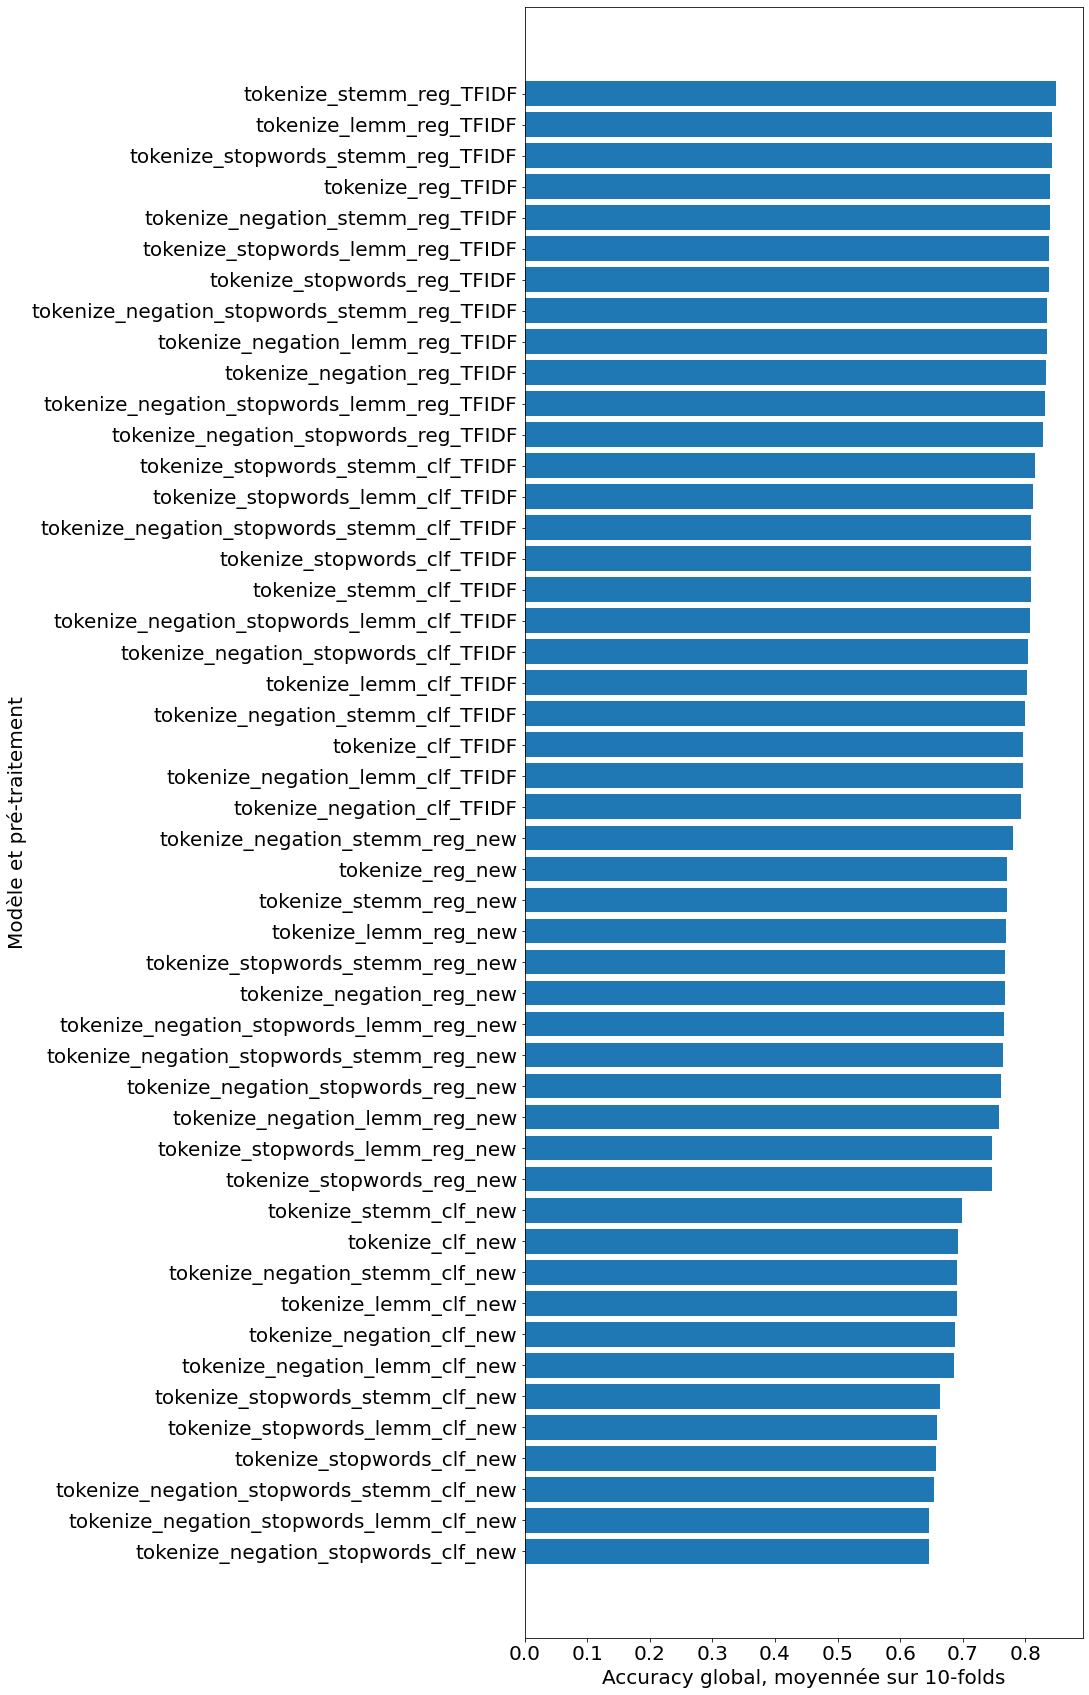

In [ ]:
font = {'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

keys = list(sorted_results.keys())
values = list(sorted_results.values())

plt.figure(figsize=(10,30))
plt.barh(keys, values)
plt.xlabel("Accuracy global, moyennée sur 10-folds")
plt.ylabel("Modèle et pré-traitement")
plt.show()


On observe donc que, basé sur le *accuracy* global, tous les modèles utilisant la représentation TF-IDF performent mieux que les modèles utilisant l'autre représentation. Cependant, comme mentionné précédemment, la seconde représentation vectorielle permet malgré tout d'améliorer la performance pour les observations négatives, ce qui est un avantage non-négligeable (malgré que le *accuracy* global en soit affecté).

On observe également que tous les modèles de régression logistique avec TF-IDF sont en premier, ensuite les modèles bayesien TF-IDF, ensuite les modèles de régression logistique avec la nouvelle représentation et finalement les modèles bayesien avec la nouvelle représentation. On en déduit donc que les étapes de pré-traitements permettent de légèrement modifier la performance, mais la performance générale d'un modèle est plutôt déterminé par son architecture et la transformation vectorielle utilisée pour représenter les données.

Finalement, comparons le *accuracy* global lorsque simplement évalué sur *test_data* vs le 10-folds.

- tokenize_negation_stopwords_stemm_clf_TFIDF: 0.8179 vs 0.8095
- tokenize_stemm_reg_TFIDF: 0.8567 vs 0.8489
- tokenize_negation_stemm_clf_new: **0.7950 vs 0.6909**
- tokenize_reg_new: 0.8079 vs 0.7709

On note donc une différence de plus de 10% pour le classificateur de Bayes choisis, selon la nouvelle représentation. Cela démontre donc l'importance de faire de la cross-validation. L'évaluation sur seulement 1-fold a généré une performance anormalement élevé (i.e. que nous avons été *chanceux* et que le partionnement a résulté en un ensemble de test plus facile à prédire). Lorsqu'évalué sur seulement 1-fold, les métriques de perfomances sont complètement dépendantes de la distribution de l'échantillon. Faire de la cross-validation, en moyennant sur plus d'un fold, permet de mitiger cet effet. 

Il aurait également intéressant de conserver les 10 *accuracy* de chacun des folds, d'ajuster une distribution normale (si adéquate) sur ces 10 points et de calculer la p-value de la valeur obtenue avec la simple évaluation sur *test_data*. Cela nous donnerait une idée pour savoir si la valeur sur un unique fold était un coup de chance, ou si elle représente bel et bien la performance du modèle.

#### c) Que se passe-t-il lorsque le paramètre de régularisation de la régression logisque (C) est augmenté ?

Voici la définition du paramètre *C* selon la documentation de la librairie *sklearn*:


*C: float, default=1.0. Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.*


*C* est un paramètre des modèles de type *régression logistique*. Ainsi, il n'est pas défini pour les modèles de type *Naive Bayes*. On étudie donc l'effet du paramètre *C* uniquemment sur le modèle de type *régression logistique* ayant le mieux performé lors des expériences précédentes. Considérant les résultats générés, la représentation *tf-idf* est utilisé ici. On utilise la combinaison *tokenization, stemming* comme étape de traitement, puisque c'est la combinaison ayant été le plus en mesure de détecter la classe négative (comparativement aux autres combinaisons d'étapes de traitement). 

Plus *C* est grand, moins l'amplitude de la régularisation est importante. Un petit *C* représente donc une forte régularisation lors de l'ajustement de la régression logistique. 

In [ ]:
def get_results_effect_of_c(c, combination, representation = "tfidf"):


    # Initialisation
    results_df = pd.DataFrame(columns=["C value",
                                    "Accuracy", 
                                   "Prec_false", 
                                   "Recall_false", 
                                   "F1_false", 
                                   "Acc_false", 
                                   "Prec_true", 
                                   "Recall_true", 
                                   "F1_true",
                                   "Acc_true"])
    
    # Pré-traitement
    preproc_corpus_train = preprocess_corpus_for_classification(train_data[0], combination[0], combination[1], combination[2], combination[3])
    preproc_corpus_test = preprocess_corpus_for_classification(test_data[0], combination[0], combination[1], combination[2], combination[3])
    
    y_train = train_data[1]
    y_test = test_data[1]
    
    # Sélection de la représentation vectorielle
    if representation == "tfidf":
        X_train, X_test = TFIDF_vectorize(preproc_corpus_train, preproc_corpus_test)
    elif representation == "new_representation":
        X_train = get_new_representation(preproc_corpus_train, y_train)
        X_test = get_new_representation(preproc_corpus_test, y_test)
    else:
        print("ERROR: choose between tfidf or new_representation for the vectorization of the observations")
        

    
    
    # Évaluation de la performance pour chaque valeur de C. On reprend toutes les métriques, évaluées par classe.
    for c_value in c:
        model = LogisticRegression(C=c_value, max_iter=1000)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)

        results_df = results_df.append({"C value":c_value,
                                    "Accuracy":report["accuracy"], 
                                   "Prec_false":report["False"]["precision"], 
                                   "Recall_false":report["False"]["recall"], 
                                   "F1_false":report["False"]["f1-score"], 
                                   "Acc_false":get_acc_per_class(y_test, y_pred)[0], 
                                   "Prec_true":report["True"]["precision"], 
                                   "Recall_true":report["True"]["recall"], 
                                   "F1_true":report["True"]["f1-score"],
                                   "Acc_true":get_acc_per_class(y_test, y_pred)[1]},
                         ignore_index=True)
    return results_df

In [ ]:
c = np.linspace(0.5,10,77)
tfidf_effect_of_c = get_results_effect_of_c(c, [0,0,1,0], "tfidf")

In [ ]:
tfidf_effect_of_c

,C value,Accuracy,Prec_false,Recall_false,F1_false,Acc_false,Prec_true,Recall_true,F1_true,Acc_true
0,0.500,0.842786,0.782353,0.523622,0.627358,0.523622,0.855090,0.950732,0.900378,0.950732
1,0.625,0.849751,0.781421,0.562992,0.654462,0.562992,0.864964,0.946738,0.904005,0.946738
2,0.750,0.849751,0.775401,0.570866,0.657596,0.570866,0.866748,0.944075,0.903760,0.944075
3,0.875,0.854726,0.778351,0.594488,0.674107,0.594488,0.872996,0.942743,0.906530,0.942743
4,1.000,0.856716,0.783505,0.598425,0.678571,0.598425,0.874229,0.944075,0.907810,0.944075
5,1.125,0.858706,0.785714,0.606299,0.684444,0.606299,0.876391,0.944075,0.908974,0.944075
6,1.250,0.860697,0.787879,0.614173,0.690265,0.614173,0.878563,0.944075,0.910141,0.944075
7,1.375,0.861692,0.788945,0.618110,0.693157,0.618110,0.879653,0.944075,0.910726,0.944075
8,1.500,0.862687,0.790000,0.622047,0.696035,0.622047,0.880745,0.944075,0.911311,0.944075
9,1.625,0.861692,0.786070,0.622047,0.694505,0.622047,0.880597,0.942743,0.910611,0.942743


On note que l'on obtient exactement les même résultats pour C=1 que lors de la génération des résultats à la question 2 du tp.

Visualisons plus en détails ces résultats. Étudions l'évolution du *accuracy* global en fonction de *C*, ainsi que le *accuracy* par classe (les autres métriques de performances sont corrélées avec celles présentées). 

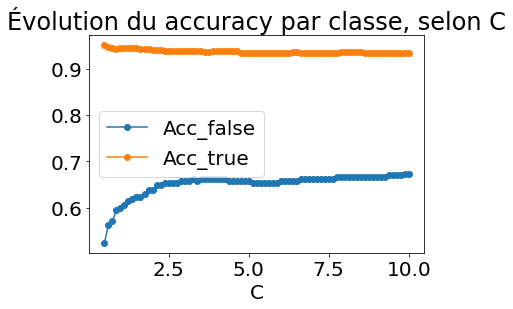

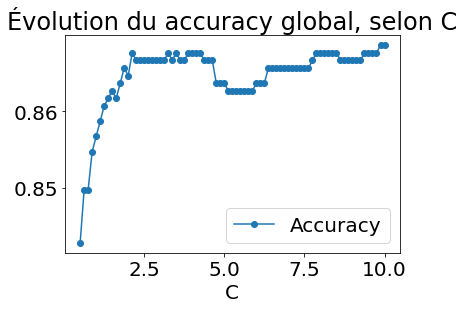

In [ ]:
plt.figure()
plt.plot(tfidf_effect_of_c["C value"], tfidf_effect_of_c["Acc_false"], "-o", label="Acc_false")
plt.plot(tfidf_effect_of_c["C value"], tfidf_effect_of_c["Acc_true"], "-o", label="Acc_true")
plt.xlabel("C")
plt.title("Évolution du accuracy par classe, selon C")
plt.legend()
plt.show()

plt.figure()
plt.plot(tfidf_effect_of_c["C value"], tfidf_effect_of_c["Accuracy"], "-o", label="Accuracy")
plt.xlabel("C")
plt.title("Évolution du accuracy global, selon C")
plt.legend()
plt.show()

On observe donc que lorsque la valeur de *C* augmente, le *accuracy* global augmente, principalement grâce au mécanisme permettant au *accuracy* sur la classe négative d'augmenter. 

Malgré tout, il est selon nous légèrement contre-intuitif que le *accuracy* global augmente lorsque *C* augmente, considérant que cela ce traduit par une diminution de l'impact du terme de régularisation. En effet, la régularisation permet habituellement des modèles plus généralisables (outil pour éviter le *overfitting*). Une hypothèse est que lorsque *C* = 1, la régularisation était trop grande, ce qui nuisait à la performance du modèle. Le plateau du *accuracy* à partir de *C* = 2.5 semble supporter cette hypothèse.

La valeur optimale pour *C* semble donc se trouver dans le voisinnage de 2.5. 

## 4. Analyse et discussion

#### En considérant les deux types de représentations, répondez aux question suivantes en reportant la question dans le notebook et en inscrivant votre réponse:

#### a) Quel est le meilleur modèle de classification en général?  Pour la classe positive et négative?

Cette question a déja été partiellement répondue lors des analyses aux sections 2 et 3. 

Le modèle performant le mieux (selon le *accuracy* global) est sans aucun doute le modèle de régression logistique, avec la représentation TF-IDF et avec uniquemment la tokenization comme étape de pré-traitement, avec un *accuracy* global de 0.8607.

Pour déterminer le modèle le plus performant pour sur chacune des classes, le F1-score sera utilisé, plutôt que le *accuracy* par classe. En effet, considérant qu'il existe une classe rare (i.e. la classe négative), nous avons des classificateurs qui ne font que prédire la classe majoritaire (i.e. la classe positive) ce qui génère un *accuracy* sur la classe positive de 1. Le *accuracy* n'est pas une bonne métrique de performance lorsqu'il existe des classes rares. Par contre, le F1-score prend en considération le taux de faux positif ainsi que le taux de faux négatif. 

Ainsi, le modèle performant le mieux (selon le F1-score) sur la classe positive est également le modèle de régression logistique, avec la représentation TF-IDF et avec uniquemment la tokenization comme étape de pré-traitement, avec un F1-score global de 0.9111 sur la classe positive.

Finalement, le modèle performant le mieux (selon le F1-score) sur la classe négative est le même modèle que pour la classe positive, avec un F1-score de 0.6774. Cependant, puisque la classe négative n'est pas la classe majoritaire, il est intéressant de déterminer le modèle ayant le *accuracy* la plus élevé pour la classe négative. Ce modèle est le modèle **Bayesien**, utilisant la **nouvelle représentation** avec la **tokenization, retrait des mots outils et le stemming**, avec un Recall_False = Accuracy_False = 0.8346.


Transposons-nous dans un contexte de mise en production du modèle. Nous cherchons donc à déterminer le modèle ayant le plus de valeur ajoutée. Si nous tentons d'identifier le sentiement d'un texte, il est beaucoup plus intéressant d'être en mesure d'identifier les documents dont le sentiement est négatif, plutôt que ceux dont le sentiement est positif. Ce sont les documents négatifs qui vont déclencher des intervention (appel de satisfaction du client, banir une personne d'une plateforme, etc.). Plus encore, pour créer le maximum de valeur, il est plus important d'avoir un recall élevé pour la classe négative que d'avoir une précision élevée. En effet, si l'entreprise est capable de se payer les faux négatifs fréquents qui surviennent lorsque la précision est basse, il est tout en son avantage de choisir un modèle avec un recall élevé sur la classe négative. Le recall représente le nombre de documents négatifs trouvés parmi tout ceux qui sont réellement négatifs. Ainsi, un recall élevé permet de détecter plus de vrais documents négatifs et de déclencher les actions à prendre pour essayer de rendre l'utiliateur plus heureux.

#### b) Quel est l’impact de l’annotation de la négation ?
Pour un reste du pré-traitement identique, l'ajout de l'annotation de la négation semble diminuer légèrement la performance des modèles. Ce phénomène est particulièrement notable pour le modèle de Bayes utilisant la nouvelle représentation. Malgré que le *accuracy* global passe de  0.71 à 0.79 lorsque l'annotation de la négation est ajouté à la simple tokenisation, le *accuracy* sur la classe négative passe de 0.76 à 0.66.

Il est fort probable que cela soit dû à l'impossibilité de raciniser les tokens auquels le suffixe *_NEG* est ajouté. En effet, cet ajout défie les règles pré-définies des stemmers pour retrouver la racine d'un mot. Malgré que l'ajout de l'annotation de la négation permet de différencier deux symboles identiques mais ayant des sens différents, il faut être très vigilant lors de sont utilisation. Cette annotation aurait dû être faite **après** la lemmatization ou le stemming. Cependant, certains mots indiquant la négation font partie des mots outils. Il est donc important de faire l'annotation avant le retrait des mots outils.

Bref, l'annotation de la négation semble être un outil puissant (i.e. ayant le potentiel d'améliorer la performance d'un modèle), mais qui a maladroitement été implémenté lors de ce tp.

In [ ]:
words = ["organization", "organization_NEG"]
stemmer = nltk.PorterStemmer()
for word in words:
    print(stemmer.stem(word))

organ
organization_neg


#### c) La suppression des stopwords est-elle une bonne idée pour l’analyse de sentiments ?
Pour chacune des expériences performées lors de ce tp, le retrait des mots outils (lorsque comparé au même pré-traitement, mais en gardant le mots outils) a entraîné une performance similaire ou moindre.

En effet, bien que le retrait des mots outils permet de réduire la cardinalité du vocabulaire en enlevant plusieurs mots vides de sens ("I", "you", "the", etc.), le retrait des mots outils retire également des mots indiquant explicitement des sentiements négatifs (tels que "no" et "never"). Ainsi, le retrait des mots outils, excluant les mots à connotation négative, pourrait être envisagé comme continuité de ce tp. 

#### d) Le stemming et/ou la lemmatisation sont-ils souhaitables dans le cadre de l’analyse de sentiments ?

Le stemming et la lemmatisation sont souhaitables dans le cadre de l'analyse de sentiments. En effet, selon nos résutlats empiriques issus de la cross-validation, les deux meilleurs classificateurs sont ceux utilisant la régression logistique avec TF-IDF et simplement une tokenisation + stemming ou lemmatisation. Cela supporte également nos réponses fournies aux question 4b) et 4c).

Les deux techniques réduisent la cardinalité du vocabulaire, ce qui rend l'espace de décision plus dense et donc permettant une meilleure séparation des deux classes. Le fléau de la dimensionnalité existe bel et bien.

Selon nos résultats, le stemming semble être à privilégier par rapport à la lemmatisation. Malgré l'aggressivité du stemming, elle semble générer de meilleurs résultats que la lemmatisation. 

## 5. Contribution

Complétez la section en haut du notebook indiquant la contribution de chaque membre de l’équipe en indiquant ce qui a été effectué par chaque membre et le pourcentage d’effort du membre dans le TP. 